<a href="https://colab.research.google.com/github/shinbad/can_bus/blob/main/CAN_ANN_datadiff_20240702.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 전처리  
- 각 ID별로 Timediff 값 추가
- 몇 ID가 test데이터에 공격데이터의 수가 부족해 테스트가 안되는 문제가 발생
- 따라서 디코딩 과정에서 데이터 수가 너무 많아 split했던 data들을 각 ID별로 concat해서 데이터의 양을 늘림


---  
**<데이터 크기로 인한 split 과정>**  
Pre_train_D_1 ->
  - decoded_can_data_AddDLC_1_0 ->
      - /filtered_data_AddDLC_1_0/pre_train_D_1_0_ID_{id}   (총 56개)
  - decoded_can_data_AddDLC_1_1 ->
      - /filtered_data_AddDLC_1_1/pre_train_D_1_1_ID_{id}   (총 56개)

Pre_train_D_2 ->
  - decoded_can_data_AddDLC_2_0 ->
      - /filtered_data_AddDLC_2_0/pre_train_D_2_0_ID_{id}   (총 56개)
  - decoded_can_data_AddDLC_2_1 ->
      - /filtered_data_AddDLC_2_1/pre_train_D_2_1_ID_{id}   (총 56개)

=> 총 224개의 파일 생성

**<학습을 위한 concat과정>**   
 동일한 id  
combined_df ->
 - pre_train_D_**1_0**_ID_{id} + pre_train_D_**1_1**_ID_{id} + pre_train_D_**2_0**_ID_{id} + pre_train_D_**2_1**_ID_{id}

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# 주어진 ID 리스트
ids = ['251', '2B0', '381', '340', '260', '47F', '329', '164', '387', '394',
       '4F1', '130', '140', '356', '153', '220', '367', '368', '412',
       '470', '420', '421', '389', '386', '492', '391', '485', '490',
       '593', '484', '48A', '50C', '58B', '436', '541', '507', '4A7', '520',
       '53E', '495', '500', '483', '4A2', '50A', '043', '544',
       '559', '410', '07F', '57F', '5B0']

       # '38D', '366', '563', '52A', '553' -> class 부족

# 빈도수 분포; ID 별 메시지 TimeDelta 값(ms)
can_freqs = {'000': 2.0,
      '043': 1.0, '07F': 1.0, '130': 0.01, '140': 0.01, '153': 0.01, '164': 0.01, '220': 0.01, '251': 0.01,
      '260': 0.01, '2B0': 0.01, '329': 0.01, '340': 0.01, '356': 0.01, '366': 0.01, '367': 0.01, '368': 0.01, '381': 0.02,
      '386': 0.02, '387': 0.02, '389': 0.02, '38D': 0.02, '391': 0.02, '394': 0.02, '410': 0.2, '412': 0.2, '420': 0.02,
      '421': 0.02, '42D': 0.1, '436': 0.05, '44E': 0.2, '453': 0.02, '470': 0.02, '479': 0.1, '47F': 0.02, '483': 0.2,
      '484': 0.07, '485': 0.05, '48A': 0.05, '48C': 0.2, '490': 0.05, '492': 0.05, '495': 0.1, '49F': 0.2, '4A2': 0.5,
      '4A4': 2.0, '4A7': 0.5, '4A9': 0.2, '4C9': 0.2, '4CB': 0.2, '4F1': 0.02, '500': 0.1, '507': 0.1, '50A': 0.2,
      '50C': 0.1, '50E': 0.2, '520': 0.1, '52A': 0.2, '53B': 0.2, '53E': 0.1, '53F': 0.2, '541': 0.1, '544': 0.2,
      '553': 0.2, '559': 0.2, '563': 0.5, '568': 0.1, '572': 0.2, '57F': 1.5, '58B': 0.05, '593': 0.2, '5A6': 0.2,
      '5B0': 1.0, '5BE': 1.0, '5CD': 0.2, '7C4': 2.0, '7CC': 2.0, '7D0': 2.0, '7D4': 2.0, '7D8': 2.0, '7DC': 2.0 }

In [ ]:
# 데이터 프레임을 저장할 딕셔너리 생성
dfs_by_id_train = {}

# 반복문을 통해 각 ID에 대해 데이터 로드 및 전처리 후 결합하여 딕셔너리에 추가
for id in ids:
    id_dfs = []
    for folder_number in range(1, 3):  # 2개의 폴더를 처리할 것으로 가정
        for j in range(2):  # ID가 0과 1인 두 가지 경우를 처리할 것으로 가정
            file_path = f'/content/drive/MyDrive/CAN/Dataset/pre_train&submit_AddData/filtered_data_AddData_{folder_number}_{j}/pre_train_D_{folder_number}_{j}_ID_{id}.csv'
            try:
                df = pd.read_csv(file_path)
                id_dfs.append(df)
            except FileNotFoundError:
                print(f'File not found: {file_path}')

    if id_dfs:  # id_dfs 리스트가 비어 있지 않은 경우에만 concat
        combined_df = pd.concat(id_dfs, ignore_index=True)

        # TimeDiff 컬럼 추가
        # diff() : 현재 행과 이전 행 차이 계산(timestamp)
        # fillna() : 첫번째 행의 경우 이전행이 없으므로 can_freqs[id]를 이용하여 계산한다.
        combined_df['TimeDiff1'] = ((combined_df['Timestamp'].diff().fillna(can_freqs[id])))
        combined_df['TimeDiff2'] = ((combined_df['Timestamp'].diff(periods=2).fillna(can_freqs[id]*2)))
        combined_df['TimeDiff3'] = ((combined_df['Timestamp'].diff(periods=3).fillna(can_freqs[id]*3)))
        combined_df['TimeDiff4'] = ((combined_df['Timestamp'].diff(periods=4).fillna(can_freqs[id]*4)))
        combined_df['TimeDiff5'] = ((combined_df['Timestamp'].diff(periods=5).fillna(can_freqs[id]*5)))
        combined_df['TimeDiff6'] = ((combined_df['Timestamp'].diff(periods=6).fillna(can_freqs[id]*6)))

        #combined_df['DiffD2_1'] = (combined_df['D2'].diff().fillna(0))
        #combined_df['DiffD2_2'] = (combined_df['D2'].diff(periods=2).fillna(0))
        #combined_df['DiffD2_3'] = (combined_df['D2'].diff(periods=3).fillna(0))

        # 객체 타입 컬럼을 카테고리 타입으로 변환
        for col in combined_df.columns:
            if combined_df[col].dtype == 'object':
                combined_df[col] = combined_df[col].astype('category')

        # 모든 값이 0인 경우 제외
        if (combined_df.drop(['Timestamp', 'Arbitration_ID', 'SubClass', 'DLC'], axis=1) == 0).all().all():
            print(f"ID {id}는 모든 값이 0이므로 제외합니다.")
        else:
            dfs_by_id_train[f'df_{id}_combined'] = combined_df

In [ ]:
dfs_by_id_train['df_260_combined']

,Timestamp,Arbitration_ID,SubClass,DLC,D0,D1,D2,D3,D4,D5,...,TQI_MAX,SPK_TIME_CUR,AliveCounter,CF_Ems_AclAct,TimeDiff1,TimeDiff2,TimeDiff3,TimeDiff4,TimeDiff5,TimeDiff6
0,0.007005,260,Normal,8,5,52,2,48,0,188,...,73.4375,-2.25,1.0,0.0,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000
1,0.016660,260,Normal,8,5,52,2,48,0,188,...,73.4375,-2.25,2.0,0.0,0.009655,0.020000,0.030000,0.040000,0.050000,0.060000
2,0.026868,260,Normal,8,5,52,2,48,0,188,...,73.4375,-2.25,3.0,0.0,0.010208,0.019863,0.030000,0.040000,0.050000,0.060000
3,0.036675,260,Normal,8,5,52,2,48,0,188,...,73.4375,-2.25,0.0,0.0,0.009807,0.020015,0.029670,0.040000,0.050000,0.060000
4,0.046681,260,Normal,8,5,52,2,48,0,188,...,73.4375,-2.25,1.0,0.0,0.010006,0.019813,0.030021,0.039676,0.050000,0.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66119,167.399959,260,Normal,8,5,43,0,48,0,188,...,73.4375,-3.00,1.0,0.0,0.010692,0.019379,0.030830,0.040898,0.050214,0.060771
66120,167.409276,260,Normal,8,5,43,0,48,0,188,...,73.4375,-3.00,2.0,0.0,0.009317,0.020009,0.028696,0.040147,0.050215,0.059531
66121,167.419839,260,Normal,8,5,43,0,48,0,188,...,73.4375,-3.00,3.0,0.0,0.010563,0.019880,0.030572,0.039259,0.050710,0.060778
66122,167.429246,260,Normal,8,5,43,1,48,0,188,...,73.4375,-3.00,0.0,0.0,0.009407,0.019970,0.029287,0.039979,0.048666,0.060117


In [ ]:
# 데이터 프레임을 저장할 딕셔너리 생성
dfs_by_id_test = {}

# 반복문을 통해 각 ID에 대해 데이터 로드 및 전처리 후 결합하여 딕셔너리에 추가
for id in ids:
    id_dfs = []
    for folder_number in range(4):  # 2개의 폴더를 처리할 것으로 가정
        file_path = f'/content/drive/MyDrive/CAN/Dataset/pre_train&submit_AddData/filtered_data_Submit_{folder_number}/pre_sumbit_D_{folder_number}_ID_{id}.csv'
        try:
            df = pd.read_csv(file_path)
            id_dfs.append(df)
        except FileNotFoundError:
            print(f'File not found: {file_path}')

    if id_dfs:  # id_dfs 리스트가 비어 있지 않은 경우에만 concat
        combined_dfS = pd.concat(id_dfs, ignore_index=True)

        # TimeDiff 컬럼 추가
        # diff() : 현재 행과 이전 행 차이 계산(timestamp)
        # fillna() : 첫번째 행의 경우 이전행이 없으므로 can_freqs[id]를 이용하여 계산한다.
        combined_dfS['TimeDiff1'] = ((combined_dfS['Timestamp'].diff().fillna(can_freqs[id])))
        combined_dfS['TimeDiff2'] = ((combined_dfS['Timestamp'].diff(periods=2).fillna(can_freqs[id]*2)))
        combined_dfS['TimeDiff3'] = ((combined_dfS['Timestamp'].diff(periods=3).fillna(can_freqs[id]*3)))
        combined_dfS['TimeDiff4'] = ((combined_dfS['Timestamp'].diff(periods=4).fillna(can_freqs[id]*4)))
        combined_dfS['TimeDiff5'] = ((combined_dfS['Timestamp'].diff(periods=5).fillna(can_freqs[id]*5)))
        combined_dfS['TimeDiff6'] = ((combined_dfS['Timestamp'].diff(periods=6).fillna(can_freqs[id]*6)))

        #combined_dfS['DiffD2_1'] = (combined_dfS['D2'].diff().fillna(0))
        #combined_dfS['DiffD2_2'] = (combined_dfS['D2'].diff(periods=2).fillna(0))
        #combined_dfS['DiffD2_3'] = (combined_dfS['D2'].diff(periods=3).fillna(0))

        # 객체 타입 컬럼을 카테고리 타입으로 변환
        for col in combined_dfS.columns:
            if combined_dfS[col].dtype == 'object':
                combined_dfS[col] = combined_dfS[col].astype('category')

        # 모든 값이 0인 경우 제외
        if (combined_dfS.drop(['Timestamp', 'Arbitration_ID', 'SubClass', 'DLC'], axis=1) == 0).all().all():
            print(f"ID {id}는 모든 값이 0이므로 제외합니다.")
        else:
            dfs_by_id_test[f'dfS_{id}_combined'] = combined_dfS

In [ ]:
dfs_by_id_test['dfS_260_combined']

,Timestamp,Arbitration_ID,SubClass,DLC,D0,D1,D2,D3,D4,D5,...,SPK_TIME_CUR,Checksum,AliveCounter,CF_Ems_AclAct,TimeDiff1,TimeDiff2,TimeDiff3,TimeDiff4,TimeDiff5,TimeDiff6
0,0.000457,260,Normal,8,5,38,1,48,0,187,...,-3.00,11.0,2.0,0.0,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000
1,0.010557,260,Normal,8,5,38,1,48,0,187,...,-3.00,10.0,3.0,0.0,0.010100,0.020000,0.030000,0.040000,0.050000,0.060000
2,0.020474,260,Normal,8,5,38,1,48,0,187,...,-3.00,13.0,0.0,0.0,0.009917,0.020017,0.030000,0.040000,0.050000,0.060000
3,0.030472,260,Normal,8,5,38,1,48,0,187,...,-3.00,12.0,1.0,0.0,0.009998,0.019915,0.030015,0.040000,0.050000,0.060000
4,0.040468,260,Normal,8,5,38,1,48,0,187,...,-3.00,11.0,2.0,0.0,0.009996,0.019994,0.029911,0.040011,0.050000,0.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51047,122.556536,260,Normal,8,6,35,2,48,0,194,...,-3.75,8.0,0.0,0.0,0.009688,0.019956,0.029780,0.039980,0.049779,0.059974
51048,122.566762,260,Normal,8,6,35,2,48,0,193,...,-4.50,10.0,1.0,0.0,0.010226,0.019914,0.030182,0.040006,0.050206,0.060005
51049,122.576531,260,Normal,8,6,35,2,48,0,193,...,-4.50,9.0,2.0,0.0,0.009769,0.019995,0.029683,0.039951,0.049775,0.059975
51050,122.586916,260,Normal,8,6,35,2,48,0,193,...,-4.50,8.0,3.0,0.0,0.010385,0.020154,0.030380,0.040068,0.050336,0.060160


## 학습, 테스트 데이터 split & 모델 학습

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

In [ ]:
def prepare_can_data(df_can):
    X = df_can.drop(['SubClass', 'Arbitration_ID', 'D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7'], axis=1)
    y = df_can['SubClass']
    return X, y

In [ ]:
# id별 학습 및 테스트 셋
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

def id_train_test_set(dfs_by_id_train, dfs_by_id_test, data_id):
    # 데이터프레임 선택
    df_combined_train = dfs_by_id_train[f'df_{data_id}_combined']
    df_combined_test = dfs_by_id_test[f'dfS_{data_id}_combined']

    train_columns = df_combined_train.columns
    df_combined_test = df_combined_test[train_columns]

    X_train, y_train = prepare_can_data(df_combined_train)
    X_test, y_test = prepare_can_data(df_combined_test)

    categorical_columns = X_train.select_dtypes(include=['category']).columns
    X_train = pd.get_dummies(X_train, columns=categorical_columns)
    X_test = pd.get_dummies(X_test, columns=categorical_columns)

    cols = X_train.columns
    # 정규화
    scaler = MinMaxScaler()
    X_train.iloc[:,1:-6] = scaler.fit_transform(X_train.iloc[:,1:-6])
    X_train_scaler = X_train.iloc[:,1:-6].astype(np.float32)

    X_test.iloc[:,1:-6] = scaler.transform(X_test.iloc[:,1:-6])
    X_test_scaler = X_test.iloc[:,1:-6].astype(np.float32)

    # 클래스 레이블을 숫자로 인코딩
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)


    return X_train_scaler, X_test_scaler, y_train_encoded, y_test_encoded, label_encoder.classes_

In [ ]:
def model_train(X_train_ex, X_test_ex, y_train_encoded, y_test_encoded, class_labels):
    # 조기 종료
    early_stopping = EarlyStopping(
          monitor='val_loss',
          patience=5,
          restore_best_weights=True
      )

    # 모델 구축(LSTM)
    #model1
    initializer = "glorot_uniform"
    constraints = None

    model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, input_dim=X_train_ex.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints, activation='relu'),
      tf.keras.layers.Dense(128, input_dim=X_train_ex.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, input_dim=X_train_ex.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, input_dim=X_train_ex.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
      tf.keras.layers.Dense(len(class_labels),activation='softmax')
      ])

    # 모델 컴파일
    model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    # 모델 학습
    training_record = model.fit(X_train_ex, y_train_encoded, epochs=100, batch_size=128,
                                validation_split=0.3, callbacks=[early_stopping],verbose=1, shuffle=False)

    pred = model.predict(X_test_ex)   # 예측
    y_pred = pred.argmax(axis=1)

    # Learning Curve 시각화
    fig, ax = plt.subplots()
    plt.plot(training_record.history["loss"], label="Training Loss")
    plt.plot(training_record.history["val_loss"], label="Validation Loss")
    plt.legend()
    fig.suptitle("Loss")
    plt.show()

    return y_pred

## 모델 성능 평가

###All ID accuracy test

Processing ID: 251
Epoch 1/100
362/362 [==============================] - 4s 6ms/step - loss: 0.1820 - accuracy: 0.9737 - val_loss: 0.1031 - val_accuracy: 0.9795
Epoch 2/100
362/362 [==============================] - 3s 8ms/step - loss: 0.1116 - accuracy: 0.9854 - val_loss: 0.0970 - val_accuracy: 0.9806
Epoch 3/100
362/362 [==============================] - 5s 14ms/step - loss: 0.1041 - accuracy: 0.9857 - val_loss: 0.0967 - val_accuracy: 0.9807
Epoch 4/100
362/362 [==============================] - 4s 11ms/step - loss: 0.1006 - accuracy: 0.9857 - val_loss: 0.0961 - val_accuracy: 0.9809
Epoch 5/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0961 - accuracy: 0.9859 - val_loss: 0.0957 - val_accuracy: 0.9810
Epoch 6/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0885 - accuracy: 0.9858 - val_loss: 0.0952 - val_accuracy: 0.9810
Epoch 7/100
362/362 [==============================] - 2s 5ms/step - loss: 0.0890 - accuracy: 0.9859 - val_loss: 0.0951 -

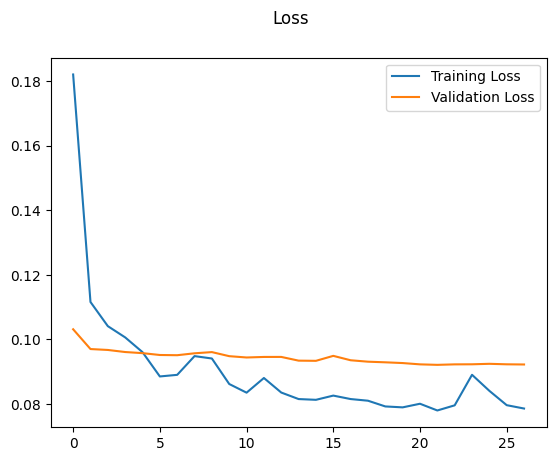

Result:

     Accuracy  F1 Score  Precision   Recall
251  0.980944  0.662577   0.993574  0.66498

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       593
      Normal       0.98      1.00      0.99     49548
      Replay       0.00      0.00      0.00       971

    accuracy                           0.98     51112
   macro avg       0.66      0.66      0.66     51112
weighted avg       0.96      0.98      0.97     51112



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


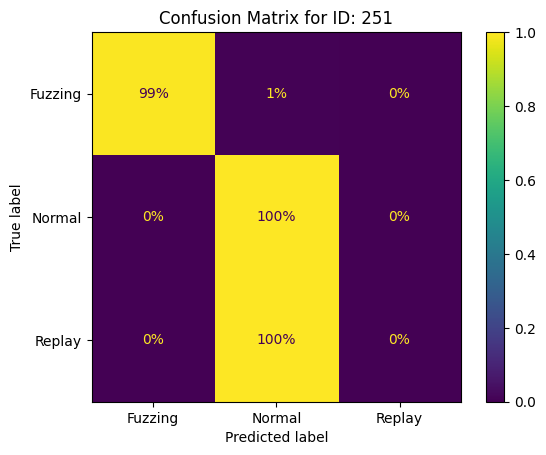

<Figure size 800x600 with 0 Axes>





Processing ID: 2B0
Epoch 1/100
362/362 [==============================] - 4s 7ms/step - loss: 0.1994 - accuracy: 0.9739 - val_loss: 0.1046 - val_accuracy: 0.9816
Epoch 2/100
362/362 [==============================] - 2s 6ms/step - loss: 0.1164 - accuracy: 0.9864 - val_loss: 0.0930 - val_accuracy: 0.9816
Epoch 3/100
362/362 [==============================] - 2s 6ms/step - loss: 0.1134 - accuracy: 0.9865 - val_loss: 0.0929 - val_accuracy: 0.9816
Epoch 4/100
362/362 [==============================] - 3s 8ms/step - loss: 0.0963 - accuracy: 0.9865 - val_loss: 0.0926 - val_accuracy: 0.9816
Epoch 5/100
362/362 [==============================] - 3s 9ms/step - loss: 0.0986 - accuracy: 0.9865 - val_loss: 0.0935 - val_accuracy: 0.9816
Epoch 6/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0943 - accuracy: 0.9865 - val_loss: 0.0933 - val_accuracy: 0.9816
Epoch 7/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0952 - accuracy: 0.9865 - val_loss: 0.0930

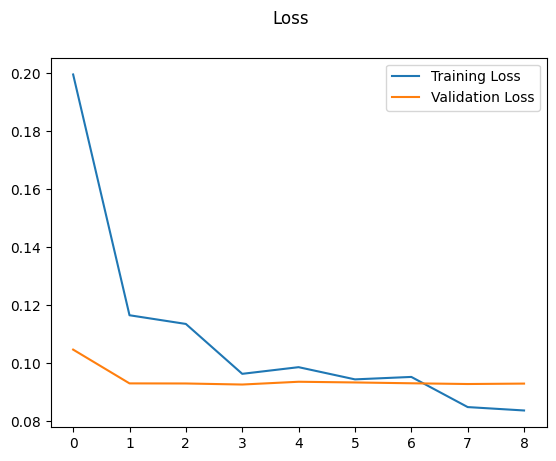

Result:

     Accuracy  F1 Score  Precision    Recall
2B0  0.980991  0.663431   0.993591  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       578
      Normal       0.98      1.00      0.99     49533
      Replay       0.00      0.00      0.00       971

    accuracy                           0.98     51082
   macro avg       0.66      0.67      0.66     51082
weighted avg       0.96      0.98      0.97     51082



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


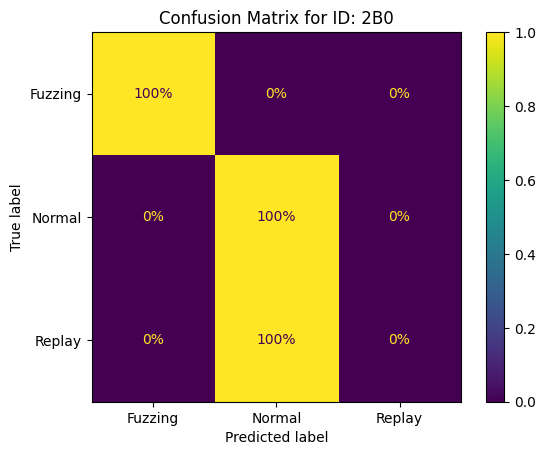

<Figure size 800x600 with 0 Axes>





Processing ID: 381
Epoch 1/100
181/181 [==============================] - 3s 7ms/step - loss: 0.2153 - accuracy: 0.9655 - val_loss: 0.1168 - val_accuracy: 0.9796
Epoch 2/100
181/181 [==============================] - 1s 6ms/step - loss: 0.1087 - accuracy: 0.9863 - val_loss: 0.1005 - val_accuracy: 0.9816
Epoch 3/100
181/181 [==============================] - 1s 6ms/step - loss: 0.1021 - accuracy: 0.9864 - val_loss: 0.1006 - val_accuracy: 0.9816
Epoch 4/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0998 - accuracy: 0.9865 - val_loss: 0.0986 - val_accuracy: 0.9817
Epoch 5/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0979 - accuracy: 0.9865 - val_loss: 0.0978 - val_accuracy: 0.9817
Epoch 6/100
181/181 [==============================] - 1s 5ms/step - loss: 0.0985 - accuracy: 0.9865 - val_loss: 0.0965 - val_accuracy: 0.9817
Epoch 7/100
181/181 [==============================] - 1s 5ms/step - loss: 0.0928 - accuracy: 0.9864 - val_loss: 0.0947

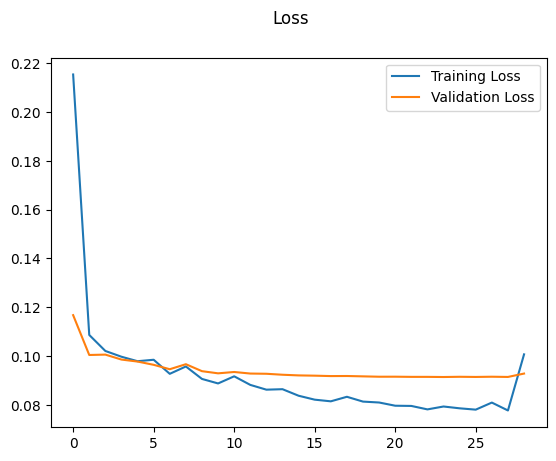

Result:

     Accuracy  F1 Score  Precision    Recall
381  0.980878  0.662148    0.99356  0.664141

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       264
      Normal       0.98      1.00      0.99     24770
      Replay       0.00      0.00      0.00       486

    accuracy                           0.98     25520
   macro avg       0.66      0.66      0.66     25520
weighted avg       0.96      0.98      0.97     25520



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


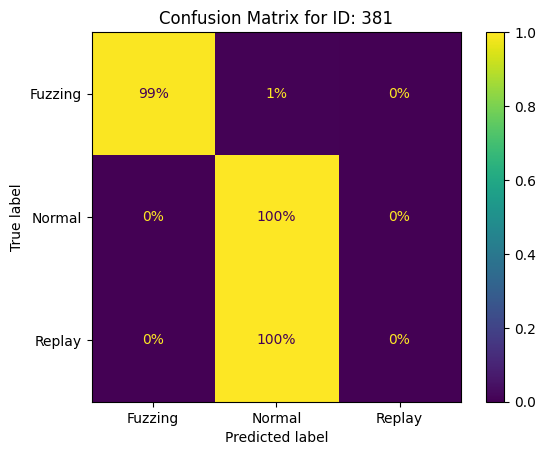

<Figure size 800x600 with 0 Axes>





Processing ID: 340
Epoch 1/100
360/360 [==============================] - 3s 6ms/step - loss: 0.1427 - accuracy: 0.9767 - val_loss: 0.1067 - val_accuracy: 0.9813
Epoch 2/100
360/360 [==============================] - 3s 7ms/step - loss: 0.0982 - accuracy: 0.9863 - val_loss: 0.0916 - val_accuracy: 0.9814
Epoch 3/100
360/360 [==============================] - 4s 10ms/step - loss: 0.0807 - accuracy: 0.9864 - val_loss: 0.0901 - val_accuracy: 0.9813
Epoch 4/100
360/360 [==============================] - 4s 11ms/step - loss: 0.0780 - accuracy: 0.9864 - val_loss: 0.0895 - val_accuracy: 0.9814
Epoch 5/100
360/360 [==============================] - 3s 8ms/step - loss: 0.0781 - accuracy: 0.9864 - val_loss: 0.0888 - val_accuracy: 0.9814
Epoch 6/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0744 - accuracy: 0.9864 - val_loss: 0.0870 - val_accuracy: 0.9815
Epoch 7/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0694 - accuracy: 0.9864 - val_loss: 0.08

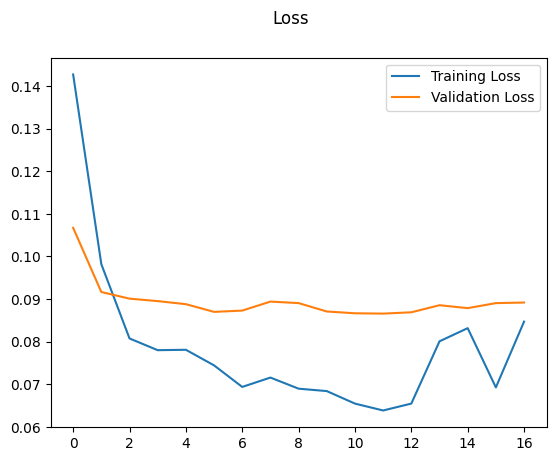

Result:

     Accuracy  F1 Score  Precision    Recall
340  0.980903  0.663435   0.993598  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       287
      Normal       0.98      1.00      0.99     49535
      Replay       0.00      0.00      0.00       970

    accuracy                           0.98     50792
   macro avg       0.66      0.67      0.66     50792
weighted avg       0.96      0.98      0.97     50792



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


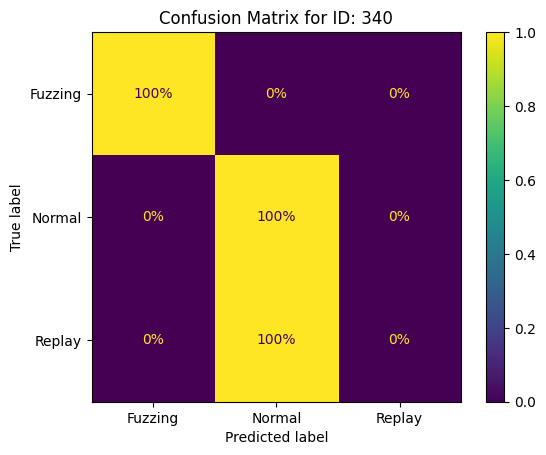

<Figure size 800x600 with 0 Axes>





Processing ID: 260
Epoch 1/100
362/362 [==============================] - 4s 9ms/step - loss: 0.1102 - accuracy: 0.9744 - val_loss: 0.0214 - val_accuracy: 0.9816
Epoch 2/100
362/362 [==============================] - 3s 9ms/step - loss: 0.0126 - accuracy: 0.9925 - val_loss: 0.0012 - val_accuracy: 0.9999
Epoch 3/100
362/362 [==============================] - 2s 6ms/step - loss: 5.4359e-04 - accuracy: 1.0000 - val_loss: 7.6394e-05 - val_accuracy: 1.0000
Epoch 4/100
362/362 [==============================] - 2s 6ms/step - loss: 1.1740e-04 - accuracy: 1.0000 - val_loss: 3.0884e-04 - val_accuracy: 0.9999
Epoch 5/100
362/362 [==============================] - 2s 6ms/step - loss: 7.7441e-05 - accuracy: 1.0000 - val_loss: 3.0497e-04 - val_accuracy: 0.9999
Epoch 6/100
362/362 [==============================] - 2s 6ms/step - loss: 1.3224e-05 - accuracy: 1.0000 - val_loss: 1.4880e-04 - val_accuracy: 0.9999
Epoch 7/100
362/362 [==============================] - 3s 8ms/step - loss: 7.4229e-06 -

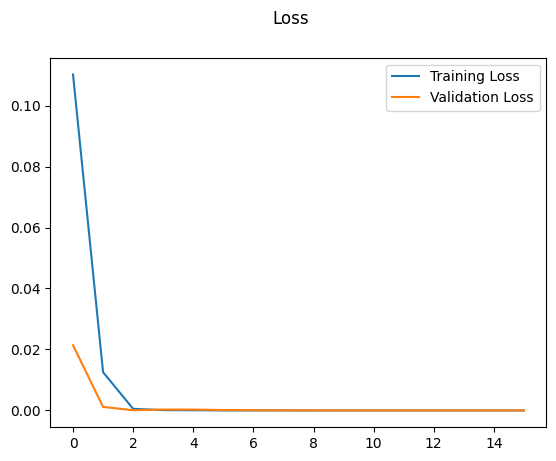

Result:

     Accuracy  F1 Score  Precision  Recall
260       1.0       1.0        1.0     1.0

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       546
      Normal       1.00      1.00      1.00     49534
      Replay       1.00      1.00      1.00       972

    accuracy                           1.00     51052
   macro avg       1.00      1.00      1.00     51052
weighted avg       1.00      1.00      1.00     51052



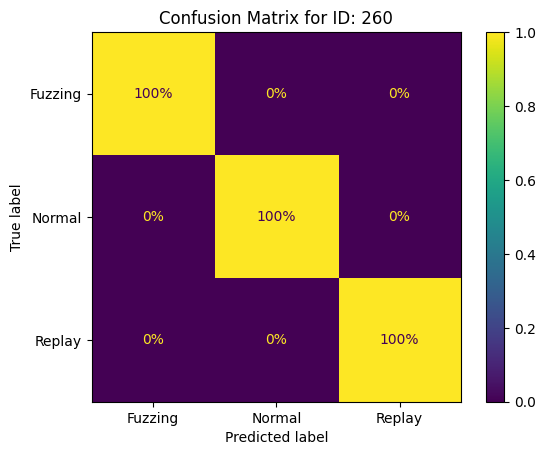

<Figure size 800x600 with 0 Axes>





Processing ID: 47F
Epoch 1/100
181/181 [==============================] - 3s 11ms/step - loss: 0.2838 - accuracy: 0.9363 - val_loss: 0.1312 - val_accuracy: 0.9625
Epoch 2/100
181/181 [==============================] - 2s 10ms/step - loss: 0.0948 - accuracy: 0.9809 - val_loss: 0.0915 - val_accuracy: 0.9810
Epoch 3/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0832 - accuracy: 0.9864 - val_loss: 0.0897 - val_accuracy: 0.9816
Epoch 4/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0767 - accuracy: 0.9864 - val_loss: 0.0879 - val_accuracy: 0.9817
Epoch 5/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0720 - accuracy: 0.9865 - val_loss: 0.0863 - val_accuracy: 0.9817
Epoch 6/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0709 - accuracy: 0.9866 - val_loss: 0.0859 - val_accuracy: 0.9817
Epoch 7/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0705 - accuracy: 0.9866 - val_loss: 0.08

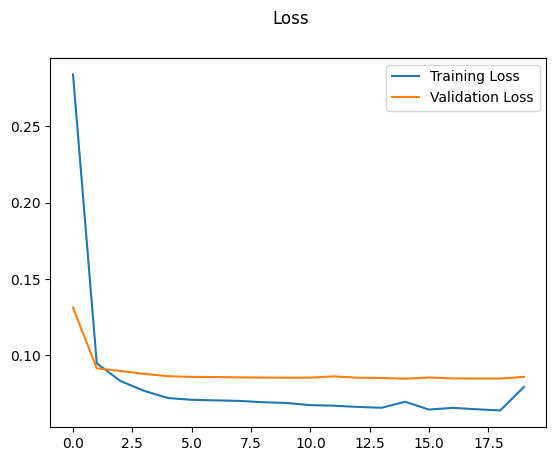

Result:

     Accuracy  F1 Score  Precision    Recall
47F  0.980946  0.663428   0.993585  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       252
      Normal       0.98      1.00      0.99     24768
      Replay       0.00      0.00      0.00       486

    accuracy                           0.98     25506
   macro avg       0.66      0.67      0.66     25506
weighted avg       0.96      0.98      0.97     25506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


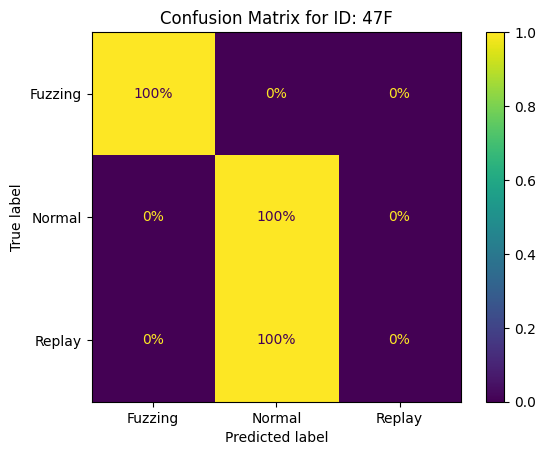

<Figure size 800x600 with 0 Axes>





Processing ID: 329
Epoch 1/100
360/360 [==============================] - 4s 7ms/step - loss: 0.1646 - accuracy: 0.9743 - val_loss: 0.1090 - val_accuracy: 0.9814
Epoch 2/100
360/360 [==============================] - 3s 9ms/step - loss: 0.1030 - accuracy: 0.9863 - val_loss: 0.0998 - val_accuracy: 0.9814
Epoch 3/100
360/360 [==============================] - 2s 6ms/step - loss: 0.0982 - accuracy: 0.9864 - val_loss: 0.0915 - val_accuracy: 0.9814
Epoch 4/100
360/360 [==============================] - 2s 6ms/step - loss: 0.1033 - accuracy: 0.9863 - val_loss: 0.0918 - val_accuracy: 0.9814
Epoch 5/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0904 - accuracy: 0.9863 - val_loss: 0.0904 - val_accuracy: 0.9814
Epoch 6/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0847 - accuracy: 0.9864 - val_loss: 0.0898 - val_accuracy: 0.9815
Epoch 7/100
360/360 [==============================] - 2s 5ms/step - loss: 0.0835 - accuracy: 0.9864 - val_loss: 0.0896

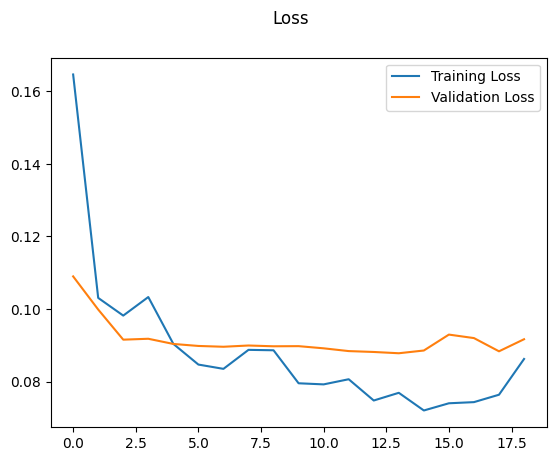

Result:

     Accuracy  F1 Score  Precision    Recall
329  0.980758  0.659877   0.993551  0.659674

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.98      0.99       286
      Normal       0.98      1.00      0.99     49518
      Replay       0.00      0.00      0.00       971

    accuracy                           0.98     50775
   macro avg       0.66      0.66      0.66     50775
weighted avg       0.96      0.98      0.97     50775



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


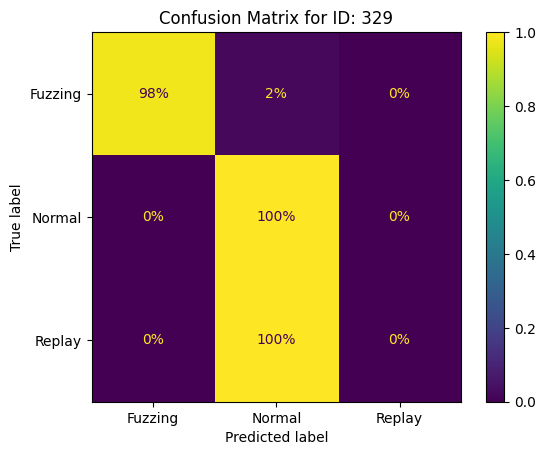

<Figure size 800x600 with 0 Axes>





Processing ID: 164
Epoch 1/100
362/362 [==============================] - 3s 6ms/step - loss: 0.1921 - accuracy: 0.9529 - val_loss: 0.1088 - val_accuracy: 0.9807
Epoch 2/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0919 - accuracy: 0.9863 - val_loss: 0.0891 - val_accuracy: 0.9816
Epoch 3/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0811 - accuracy: 0.9865 - val_loss: 0.0862 - val_accuracy: 0.9816
Epoch 4/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0794 - accuracy: 0.9865 - val_loss: 0.0931 - val_accuracy: 0.9815
Epoch 5/100
362/362 [==============================] - 3s 9ms/step - loss: 0.0792 - accuracy: 0.9865 - val_loss: 0.0849 - val_accuracy: 0.9816
Epoch 6/100
362/362 [==============================] - 3s 8ms/step - loss: 0.0675 - accuracy: 0.9865 - val_loss: 0.0845 - val_accuracy: 0.9816
Epoch 7/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0716 - accuracy: 0.9865 - val_loss: 0.0846

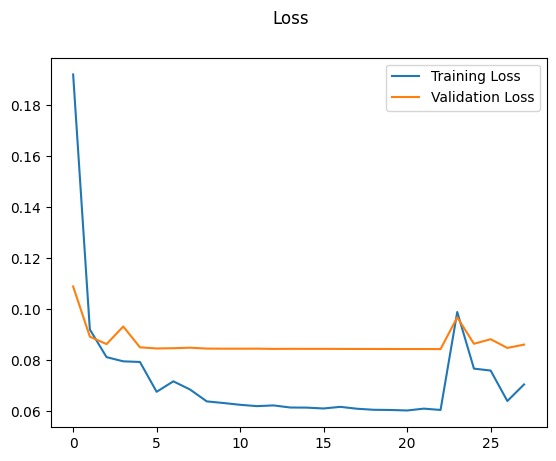

Result:

     Accuracy  F1 Score  Precision    Recall
164  0.980994  0.663433   0.993596  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       552
      Normal       0.98      1.00      0.99     49567
      Replay       0.00      0.00      0.00       971

    accuracy                           0.98     51090
   macro avg       0.66      0.67      0.66     51090
weighted avg       0.96      0.98      0.97     51090



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


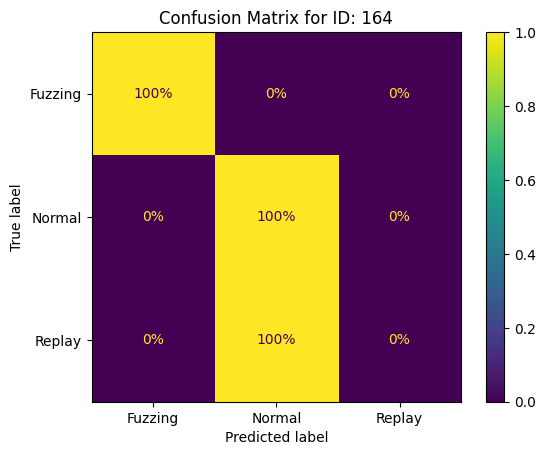

<Figure size 800x600 with 0 Axes>





Processing ID: 387
Epoch 1/100
182/182 [==============================] - 2s 7ms/step - loss: 0.2647 - accuracy: 0.9613 - val_loss: 0.1250 - val_accuracy: 0.9670
Epoch 2/100
182/182 [==============================] - 1s 6ms/step - loss: 0.1036 - accuracy: 0.9841 - val_loss: 0.0855 - val_accuracy: 0.9810
Epoch 3/100
182/182 [==============================] - 1s 6ms/step - loss: 0.0719 - accuracy: 0.9860 - val_loss: 0.0744 - val_accuracy: 0.9813
Epoch 4/100
182/182 [==============================] - 1s 6ms/step - loss: 0.0658 - accuracy: 0.9862 - val_loss: 0.0729 - val_accuracy: 0.9814
Epoch 5/100
182/182 [==============================] - 1s 6ms/step - loss: 0.0600 - accuracy: 0.9863 - val_loss: 0.0722 - val_accuracy: 0.9814
Epoch 6/100
182/182 [==============================] - 1s 6ms/step - loss: 0.0516 - accuracy: 0.9863 - val_loss: 0.0674 - val_accuracy: 0.9816
Epoch 7/100
182/182 [==============================] - 1s 6ms/step - loss: 0.0522 - accuracy: 0.9862 - val_loss: 0.0670

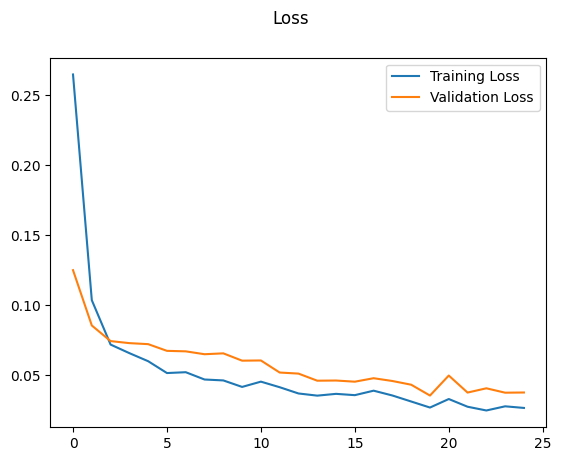

Result:

     Accuracy  F1 Score  Precision    Recall
387  0.974926  0.764345   0.771371  0.757876

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       279
      Normal       0.99      0.99      0.99     24759
      Replay       0.33      0.30      0.31       486

    accuracy                           0.97     25524
   macro avg       0.77      0.76      0.76     25524
weighted avg       0.97      0.97      0.97     25524



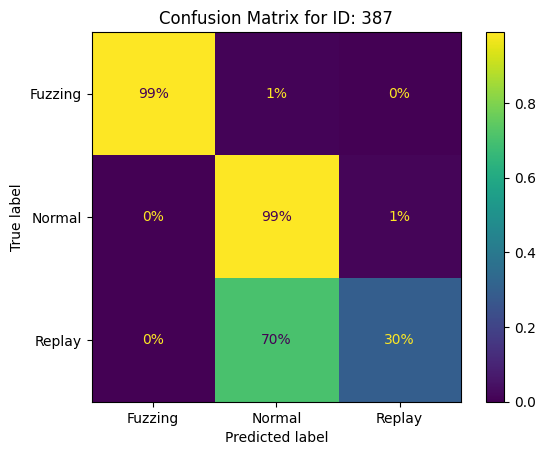

<Figure size 800x600 with 0 Axes>





Processing ID: 394
Epoch 1/100
181/181 [==============================] - 2s 7ms/step - loss: 0.2419 - accuracy: 0.9645 - val_loss: 0.1234 - val_accuracy: 0.9747
Epoch 2/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0902 - accuracy: 0.9815 - val_loss: 0.0704 - val_accuracy: 0.9816
Epoch 3/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0712 - accuracy: 0.9864 - val_loss: 0.0548 - val_accuracy: 0.9817
Epoch 4/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0510 - accuracy: 0.9864 - val_loss: 0.0451 - val_accuracy: 0.9817
Epoch 5/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0446 - accuracy: 0.9864 - val_loss: 0.0409 - val_accuracy: 0.9817
Epoch 6/100
181/181 [==============================] - 2s 10ms/step - loss: 0.0395 - accuracy: 0.9864 - val_loss: 0.0361 - val_accuracy: 0.9817
Epoch 7/100
181/181 [==============================] - 2s 10ms/step - loss: 0.0349 - accuracy: 0.9865 - val_loss: 0.03

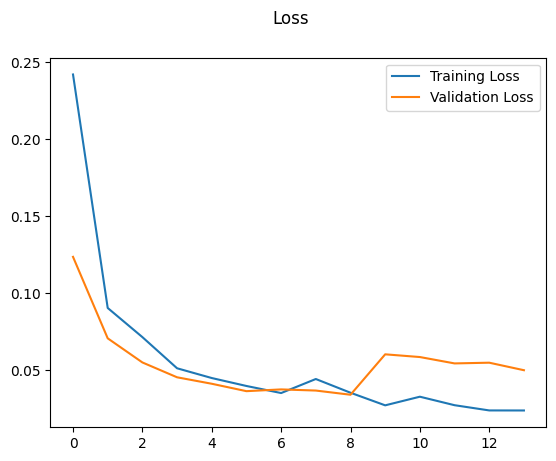

Result:

     Accuracy  F1 Score  Precision    Recall
394   0.98092  0.662785   0.993574  0.665394

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       262
      Normal       0.98      1.00      0.99     24776
      Replay       0.00      0.00      0.00       486

    accuracy                           0.98     25524
   macro avg       0.66      0.67      0.66     25524
weighted avg       0.96      0.98      0.97     25524



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


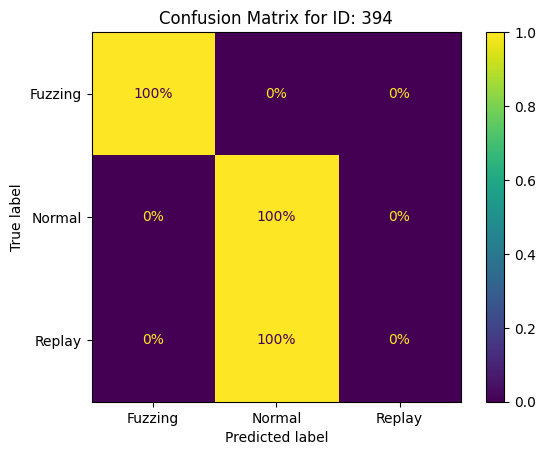

<Figure size 800x600 with 0 Axes>





Processing ID: 4F1
Epoch 1/100
181/181 [==============================] - 4s 12ms/step - loss: 0.2215 - accuracy: 0.9670 - val_loss: 0.1078 - val_accuracy: 0.9804
Epoch 2/100
181/181 [==============================] - 1s 8ms/step - loss: 0.0905 - accuracy: 0.9863 - val_loss: 0.0912 - val_accuracy: 0.9815
Epoch 3/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0798 - accuracy: 0.9864 - val_loss: 0.0900 - val_accuracy: 0.9815
Epoch 4/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0742 - accuracy: 0.9864 - val_loss: 0.0902 - val_accuracy: 0.9816
Epoch 5/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0728 - accuracy: 0.9865 - val_loss: 0.0932 - val_accuracy: 0.9816
Epoch 6/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0707 - accuracy: 0.9864 - val_loss: 0.0940 - val_accuracy: 0.9816
Epoch 7/100
181/181 [==============================] - 1s 6ms/step - loss: 0.0704 - accuracy: 0.9865 - val_loss: 0.095

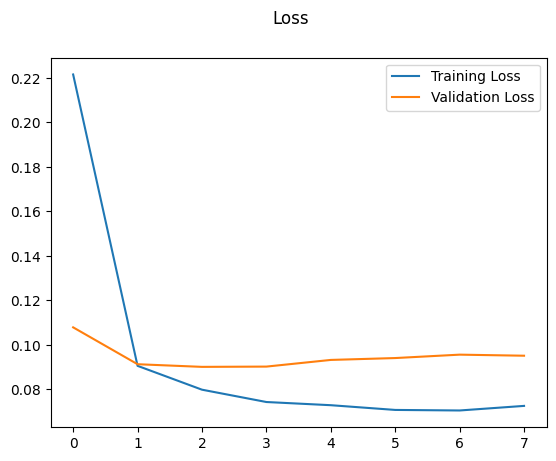

Result:

     Accuracy  F1 Score  Precision    Recall
4F1  0.980865  0.661515   0.993555  0.662893

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       265
      Normal       0.98      1.00      0.99     24753
      Replay       0.00      0.00      0.00       485

    accuracy                           0.98     25503
   macro avg       0.66      0.66      0.66     25503
weighted avg       0.96      0.98      0.97     25503



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


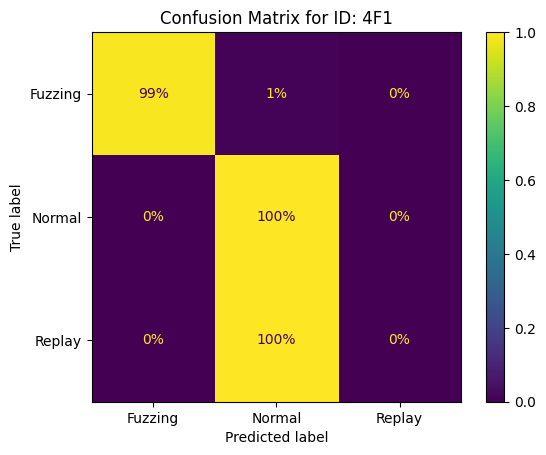

<Figure size 800x600 with 0 Axes>





Processing ID: 130
Epoch 1/100
362/362 [==============================] - 5s 10ms/step - loss: 0.1917 - accuracy: 0.9737 - val_loss: 0.1081 - val_accuracy: 0.9807
Epoch 2/100
362/362 [==============================] - 2s 6ms/step - loss: 0.1108 - accuracy: 0.9861 - val_loss: 0.0962 - val_accuracy: 0.9810
Epoch 3/100
362/362 [==============================] - 2s 6ms/step - loss: 0.1016 - accuracy: 0.9864 - val_loss: 0.0932 - val_accuracy: 0.9815
Epoch 4/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0962 - accuracy: 0.9865 - val_loss: 0.0933 - val_accuracy: 0.9815
Epoch 5/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0974 - accuracy: 0.9865 - val_loss: 0.0928 - val_accuracy: 0.9814
Epoch 6/100
362/362 [==============================] - 3s 8ms/step - loss: 0.0968 - accuracy: 0.9864 - val_loss: 0.0924 - val_accuracy: 0.9815
Epoch 7/100
362/362 [==============================] - 3s 10ms/step - loss: 0.0887 - accuracy: 0.9865 - val_loss: 0.09

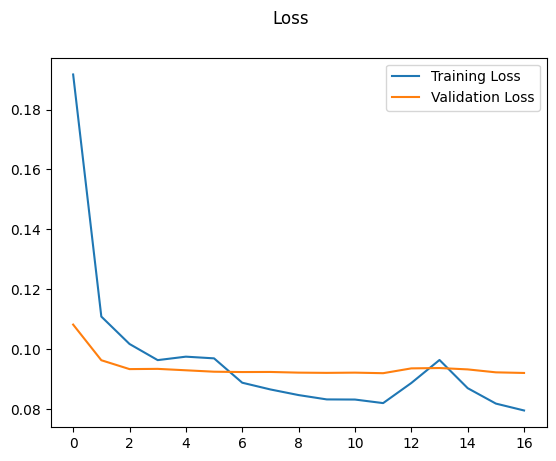

Result:

     Accuracy  F1 Score  Precision    Recall
130  0.980982  0.663138   0.993589  0.666083

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       571
      Normal       0.98      1.00      0.99     49516
      Replay       0.00      0.00      0.00       970

    accuracy                           0.98     51057
   macro avg       0.66      0.67      0.66     51057
weighted avg       0.96      0.98      0.97     51057



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


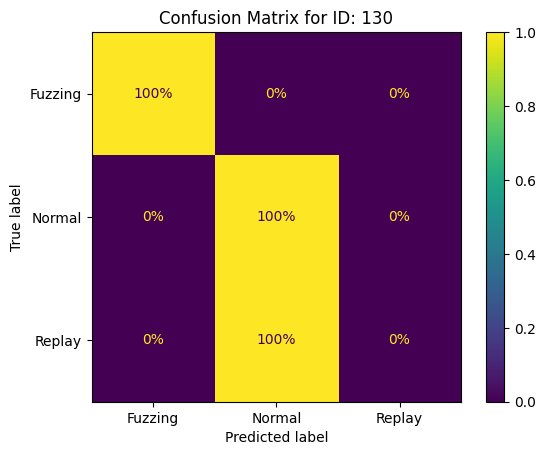

<Figure size 800x600 with 0 Axes>





Processing ID: 140
Epoch 1/100
362/362 [==============================] - 4s 7ms/step - loss: 0.1953 - accuracy: 0.9738 - val_loss: 0.1049 - val_accuracy: 0.9802
Epoch 2/100
362/362 [==============================] - 2s 6ms/step - loss: 0.1105 - accuracy: 0.9861 - val_loss: 0.0930 - val_accuracy: 0.9815
Epoch 3/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0968 - accuracy: 0.9864 - val_loss: 0.0925 - val_accuracy: 0.9816
Epoch 4/100
362/362 [==============================] - 3s 8ms/step - loss: 0.1047 - accuracy: 0.9865 - val_loss: 0.0938 - val_accuracy: 0.9816
Epoch 5/100
362/362 [==============================] - 4s 10ms/step - loss: 0.0931 - accuracy: 0.9865 - val_loss: 0.0929 - val_accuracy: 0.9816
Epoch 6/100
362/362 [==============================] - 3s 7ms/step - loss: 0.0898 - accuracy: 0.9865 - val_loss: 0.0928 - val_accuracy: 0.9815
Epoch 7/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0872 - accuracy: 0.9865 - val_loss: 0.092

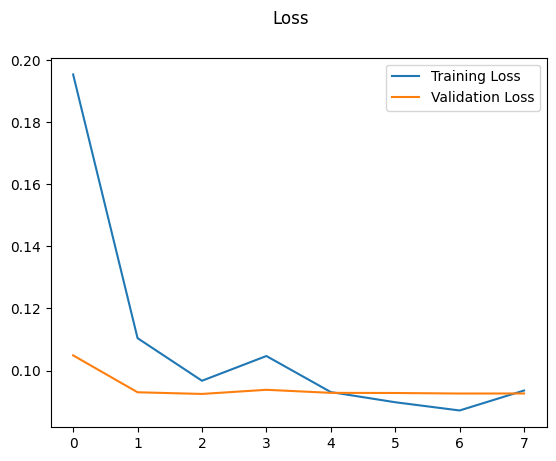

Result:

     Accuracy  F1 Score  Precision    Recall
140  0.980873  0.661568   0.993556  0.662997

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       545
      Normal       0.98      1.00      0.99     49512
      Replay       0.00      0.00      0.00       970

    accuracy                           0.98     51027
   macro avg       0.66      0.66      0.66     51027
weighted avg       0.96      0.98      0.97     51027



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


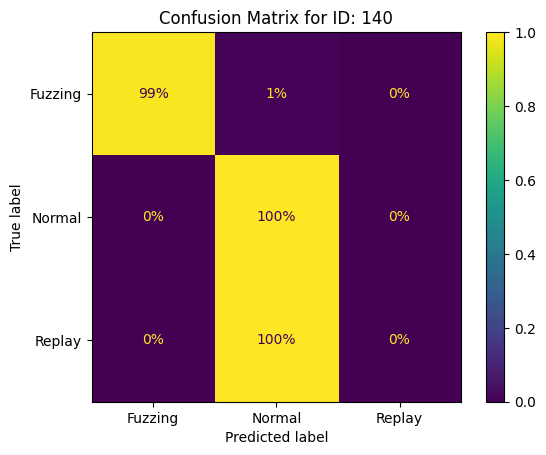

<Figure size 800x600 with 0 Axes>





Processing ID: 356
Epoch 1/100
360/360 [==============================] - 4s 7ms/step - loss: 0.2112 - accuracy: 0.9730 - val_loss: 0.1425 - val_accuracy: 0.9733
Epoch 2/100
360/360 [==============================] - 2s 6ms/step - loss: 0.1435 - accuracy: 0.9792 - val_loss: 0.1334 - val_accuracy: 0.9733
Epoch 3/100
360/360 [==============================] - 3s 9ms/step - loss: 0.1351 - accuracy: 0.9792 - val_loss: 0.1289 - val_accuracy: 0.9733
Epoch 4/100
360/360 [==============================] - 4s 10ms/step - loss: 0.1330 - accuracy: 0.9792 - val_loss: 0.1284 - val_accuracy: 0.9733
Epoch 5/100
360/360 [==============================] - 4s 10ms/step - loss: 0.1234 - accuracy: 0.9792 - val_loss: 0.1277 - val_accuracy: 0.9733
Epoch 6/100
360/360 [==============================] - 3s 9ms/step - loss: 0.1216 - accuracy: 0.9792 - val_loss: 0.1273 - val_accuracy: 0.9733
Epoch 7/100
360/360 [==============================] - 2s 6ms/step - loss: 0.1190 - accuracy: 0.9792 - val_loss: 0.12

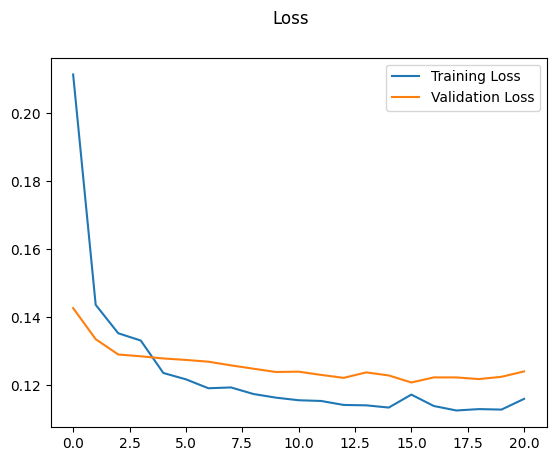

Result:

     Accuracy  F1 Score  Precision    Recall
356  0.975348  0.329173   0.991783  0.333333

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.00      0.00      0.00       282
      Normal       0.98      1.00      0.99     49575
      Replay       0.00      0.00      0.00       971

    accuracy                           0.98     50828
   macro avg       0.33      0.33      0.33     50828
weighted avg       0.95      0.98      0.96     50828



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


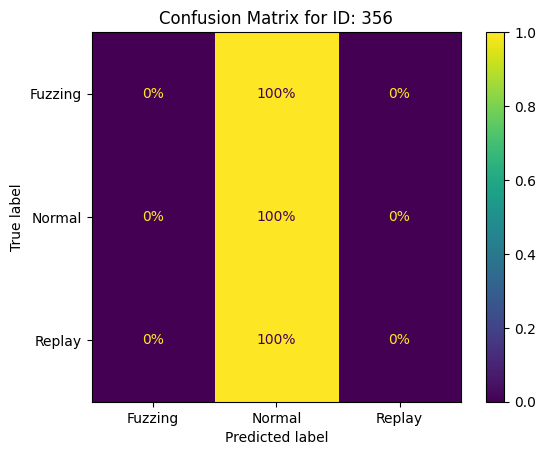

<Figure size 800x600 with 0 Axes>





Processing ID: 153
Epoch 1/100
362/362 [==============================] - 3s 7ms/step - loss: 0.1513 - accuracy: 0.9724 - val_loss: 0.1145 - val_accuracy: 0.9814
Epoch 2/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0805 - accuracy: 0.9864 - val_loss: 0.1252 - val_accuracy: 0.9813
Epoch 3/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0797 - accuracy: 0.9865 - val_loss: 0.1354 - val_accuracy: 0.9813
Epoch 4/100
362/362 [==============================] - 3s 7ms/step - loss: 0.0836 - accuracy: 0.9865 - val_loss: 0.0913 - val_accuracy: 0.9817
Epoch 5/100
362/362 [==============================] - 3s 10ms/step - loss: 0.0731 - accuracy: 0.9865 - val_loss: 0.0905 - val_accuracy: 0.9816
Epoch 6/100
362/362 [==============================] - 3s 8ms/step - loss: 0.0714 - accuracy: 0.9865 - val_loss: 0.0860 - val_accuracy: 0.9817
Epoch 7/100
362/362 [==============================] - 2s 6ms/step - loss: 0.0674 - accuracy: 0.9865 - val_loss: 0.085

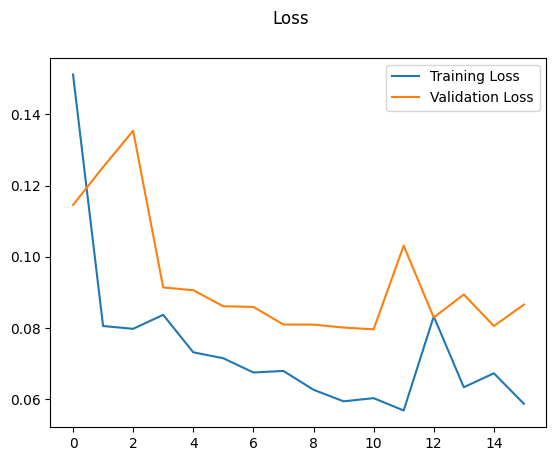

Result:

     Accuracy  F1 Score  Precision    Recall
153  0.980839  0.660974   0.993544  0.661836

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       552
      Normal       0.98      1.00      0.99     49519
      Replay       0.00      0.00      0.00       970

    accuracy                           0.98     51041
   macro avg       0.66      0.66      0.66     51041
weighted avg       0.96      0.98      0.97     51041



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


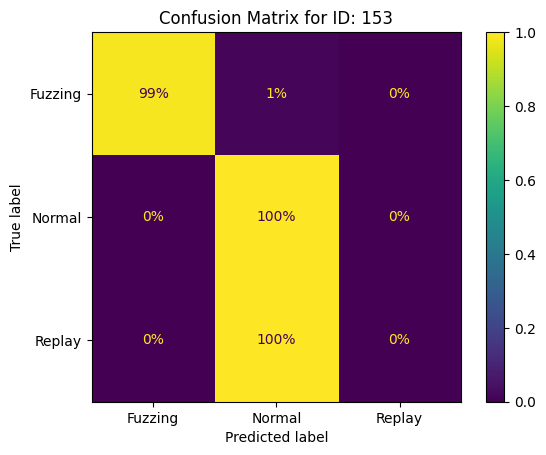

<Figure size 800x600 with 0 Axes>





Processing ID: 220
Epoch 1/100
363/363 [==============================] - 4s 7ms/step - loss: 0.1613 - accuracy: 0.9563 - val_loss: 0.1190 - val_accuracy: 0.9783
Epoch 2/100
363/363 [==============================] - 2s 6ms/step - loss: 0.0795 - accuracy: 0.9846 - val_loss: 0.1003 - val_accuracy: 0.9796
Epoch 3/100
363/363 [==============================] - 3s 7ms/step - loss: 0.0774 - accuracy: 0.9833 - val_loss: 0.1067 - val_accuracy: 0.9797
Epoch 4/100
363/363 [==============================] - 3s 9ms/step - loss: 0.0654 - accuracy: 0.9858 - val_loss: 0.1107 - val_accuracy: 0.9804
Epoch 5/100
363/363 [==============================] - 3s 8ms/step - loss: 0.0666 - accuracy: 0.9861 - val_loss: 0.1240 - val_accuracy: 0.9803
Epoch 6/100
363/363 [==============================] - 2s 6ms/step - loss: 0.0486 - accuracy: 0.9861 - val_loss: 0.1236 - val_accuracy: 0.9804
Epoch 7/100
1595/1595 [==============================] - 3s 2ms/step


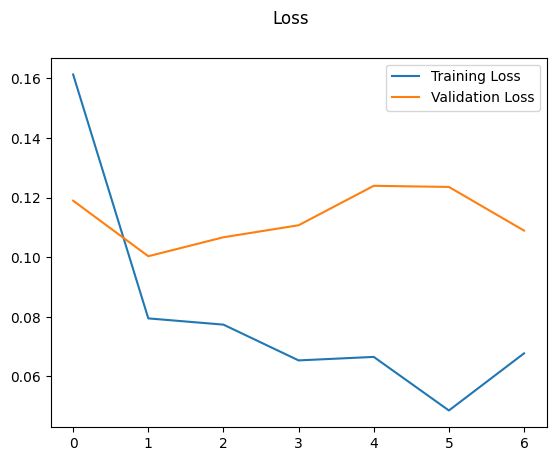

Result:

     Accuracy  F1 Score  Precision    Recall
220  0.980426  0.654541    0.98795  0.654594

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.98      0.96      0.97       555
      Normal       0.98      1.00      0.99     49512
      Replay       0.00      0.00      0.00       970

    accuracy                           0.98     51037
   macro avg       0.65      0.65      0.65     51037
weighted avg       0.96      0.98      0.97     51037



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


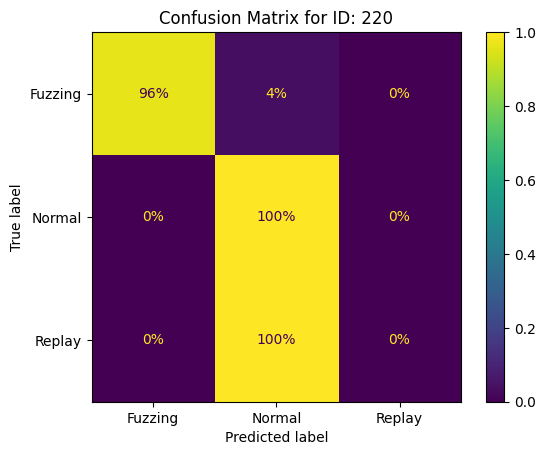

<Figure size 800x600 with 0 Axes>





Processing ID: 367
Epoch 1/100
359/359 [==============================] - 6s 10ms/step - loss: 0.1639 - accuracy: 0.9800 - val_loss: 0.1067 - val_accuracy: 0.9798
Epoch 2/100
359/359 [==============================] - 2s 7ms/step - loss: 0.1286 - accuracy: 0.9853 - val_loss: 0.1014 - val_accuracy: 0.9797
Epoch 3/100
359/359 [==============================] - 2s 7ms/step - loss: 0.1093 - accuracy: 0.9855 - val_loss: 0.1010 - val_accuracy: 0.9795
Epoch 4/100
359/359 [==============================] - 2s 7ms/step - loss: 0.1030 - accuracy: 0.9854 - val_loss: 0.1015 - val_accuracy: 0.9803
Epoch 5/100
359/359 [==============================] - 2s 7ms/step - loss: 0.0979 - accuracy: 0.9855 - val_loss: 0.0992 - val_accuracy: 0.9801
Epoch 6/100
359/359 [==============================] - 3s 10ms/step - loss: 0.1182 - accuracy: 0.9847 - val_loss: 0.1158 - val_accuracy: 0.9799
Epoch 7/100
359/359 [==============================] - 4s 10ms/step - loss: 0.1045 - accuracy: 0.9855 - val_loss: 0.1

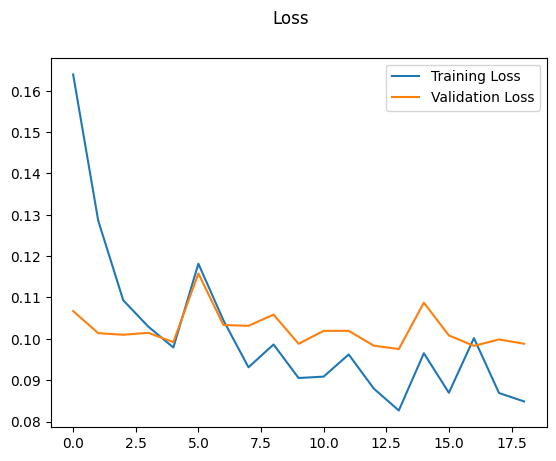

Result:

     Accuracy  F1 Score  Precision    Recall
367  0.722822  0.292067   0.664338  0.558079

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.02      0.94      0.04       276
      Normal       0.97      0.74      0.84     49544
      Replay       0.00      0.00      0.00       974

    accuracy                           0.72     50794
   macro avg       0.33      0.56      0.29     50794
weighted avg       0.95      0.72      0.82     50794



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


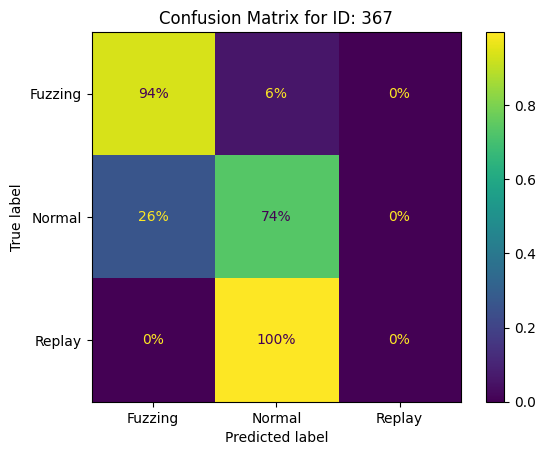

<Figure size 800x600 with 0 Axes>





Processing ID: 368
Epoch 1/100
359/359 [==============================] - 4s 8ms/step - loss: 0.1311 - accuracy: 0.9794 - val_loss: 0.0872 - val_accuracy: 0.9813
Epoch 2/100
359/359 [==============================] - 3s 9ms/step - loss: 0.0523 - accuracy: 0.9862 - val_loss: 0.1027 - val_accuracy: 0.9815
Epoch 3/100
359/359 [==============================] - 4s 10ms/step - loss: 0.0493 - accuracy: 0.9862 - val_loss: 0.1200 - val_accuracy: 0.9815
Epoch 4/100
359/359 [==============================] - 3s 7ms/step - loss: 0.0475 - accuracy: 0.9851 - val_loss: 0.1061 - val_accuracy: 0.9815
Epoch 5/100
359/359 [==============================] - 2s 7ms/step - loss: 0.0476 - accuracy: 0.9862 - val_loss: 0.1160 - val_accuracy: 0.9815
Epoch 6/100
1587/1587 [==============================] - 3s 2ms/step


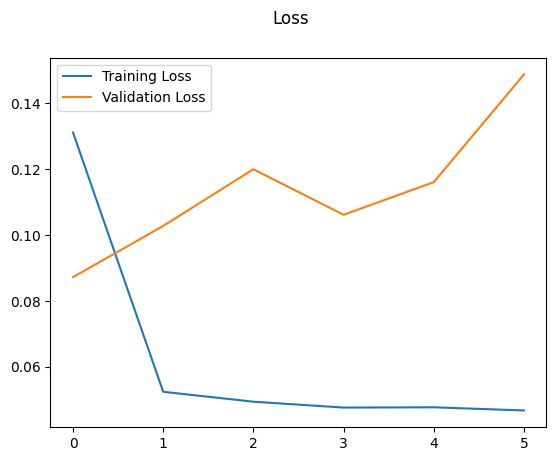

Result:

     Accuracy  F1 Score  Precision    Recall
368  0.980693  0.657267   0.993534  0.654618

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.96      0.98       249
      Normal       0.98      1.00      0.99     49538
      Replay       0.00      0.00      0.00       971

    accuracy                           0.98     50758
   macro avg       0.66      0.65      0.66     50758
weighted avg       0.96      0.98      0.97     50758



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


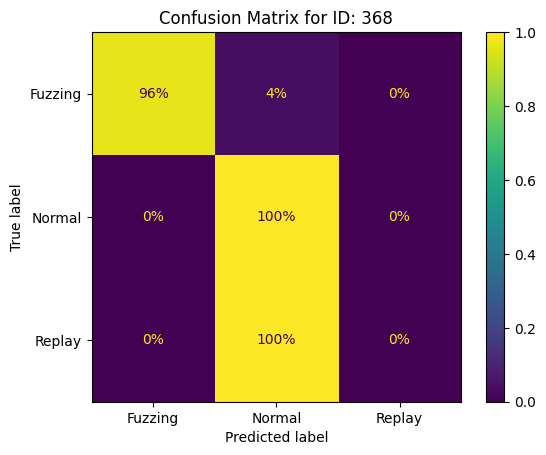

<Figure size 800x600 with 0 Axes>





Processing ID: 412
Epoch 1/100
21/21 [==============================] - 1s 18ms/step - loss: 0.7041 - accuracy: 0.8454 - val_loss: 0.3726 - val_accuracy: 0.8265
Epoch 2/100
21/21 [==============================] - 0s 9ms/step - loss: 0.2413 - accuracy: 0.9076 - val_loss: 0.1633 - val_accuracy: 0.9804
Epoch 3/100
21/21 [==============================] - 0s 10ms/step - loss: 0.1075 - accuracy: 0.9866 - val_loss: 0.1043 - val_accuracy: 0.9840
Epoch 4/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0819 - accuracy: 0.9878 - val_loss: 0.0909 - val_accuracy: 0.9840
Epoch 5/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0759 - accuracy: 0.9878 - val_loss: 0.0845 - val_accuracy: 0.9840
Epoch 6/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0692 - accuracy: 0.9878 - val_loss: 0.0831 - val_accuracy: 0.9840
Epoch 7/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0686 - accuracy: 0.9878 - val_loss: 0.0820 - val_accu

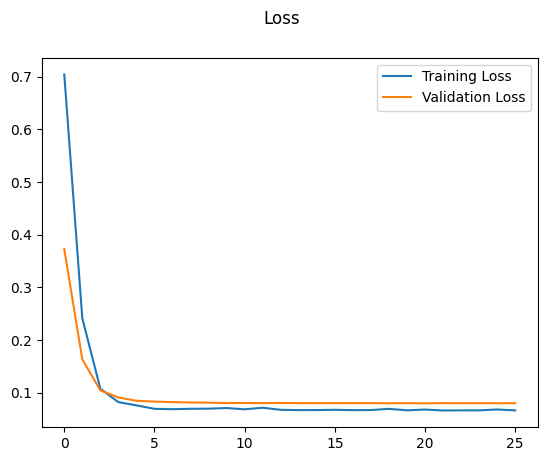

Result:

     Accuracy  F1 Score  Precision    Recall
412  0.982568  0.663399   0.993529  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       287
      Normal       0.98      1.00      0.99      2475
      Replay       0.00      0.00      0.00        49

    accuracy                           0.98      2811
   macro avg       0.66      0.67      0.66      2811
weighted avg       0.97      0.98      0.97      2811



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


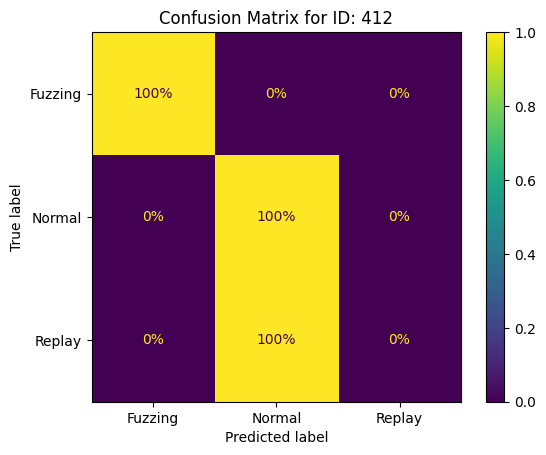

<Figure size 800x600 with 0 Axes>





Processing ID: 470
Epoch 1/100
181/181 [==============================] - 3s 12ms/step - loss: 0.2877 - accuracy: 0.9645 - val_loss: 0.1884 - val_accuracy: 0.9660
Epoch 2/100
181/181 [==============================] - 2s 9ms/step - loss: 0.1517 - accuracy: 0.9753 - val_loss: 0.1364 - val_accuracy: 0.9776
Epoch 3/100
181/181 [==============================] - 2s 10ms/step - loss: 0.1198 - accuracy: 0.9832 - val_loss: 0.1151 - val_accuracy: 0.9798
Epoch 4/100
181/181 [==============================] - 2s 10ms/step - loss: 0.1062 - accuracy: 0.9852 - val_loss: 0.1093 - val_accuracy: 0.9799
Epoch 5/100
181/181 [==============================] - 2s 11ms/step - loss: 0.1025 - accuracy: 0.9853 - val_loss: 0.1086 - val_accuracy: 0.9799
Epoch 6/100
181/181 [==============================] - 2s 10ms/step - loss: 0.0987 - accuracy: 0.9855 - val_loss: 0.1037 - val_accuracy: 0.9802
Epoch 7/100
181/181 [==============================] - 2s 9ms/step - loss: 0.1091 - accuracy: 0.9855 - val_loss: 0

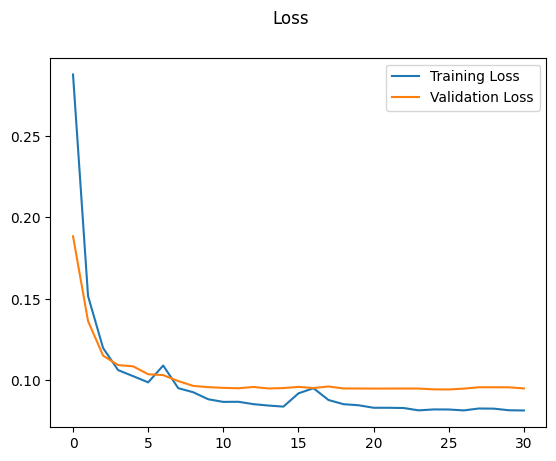

Result:

     Accuracy  F1 Score  Precision    Recall
470  0.980578  0.657995   0.993455  0.656103

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.97      0.98       284
      Normal       0.98      1.00      0.99     24716
      Replay       0.00      0.00      0.00       486

    accuracy                           0.98     25486
   macro avg       0.66      0.66      0.66     25486
weighted avg       0.96      0.98      0.97     25486



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


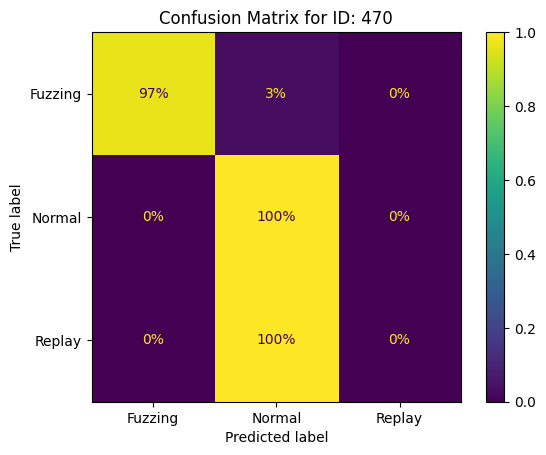

<Figure size 800x600 with 0 Axes>





Processing ID: 420
Epoch 1/100
181/181 [==============================] - 3s 8ms/step - loss: 0.2152 - accuracy: 0.9686 - val_loss: 0.1193 - val_accuracy: 0.9787
Epoch 2/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1032 - accuracy: 0.9849 - val_loss: 0.1236 - val_accuracy: 0.9798
Epoch 3/100
181/181 [==============================] - 2s 11ms/step - loss: 0.0951 - accuracy: 0.9860 - val_loss: 0.0969 - val_accuracy: 0.9814
Epoch 4/100
181/181 [==============================] - 2s 12ms/step - loss: 0.0950 - accuracy: 0.9863 - val_loss: 0.1032 - val_accuracy: 0.9813
Epoch 5/100
181/181 [==============================] - 2s 11ms/step - loss: 0.0838 - accuracy: 0.9864 - val_loss: 0.0987 - val_accuracy: 0.9812
Epoch 6/100
181/181 [==============================] - 2s 8ms/step - loss: 0.0840 - accuracy: 0.9864 - val_loss: 0.1073 - val_accuracy: 0.9802
Epoch 7/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0792 - accuracy: 0.9863 - val_loss: 0.1

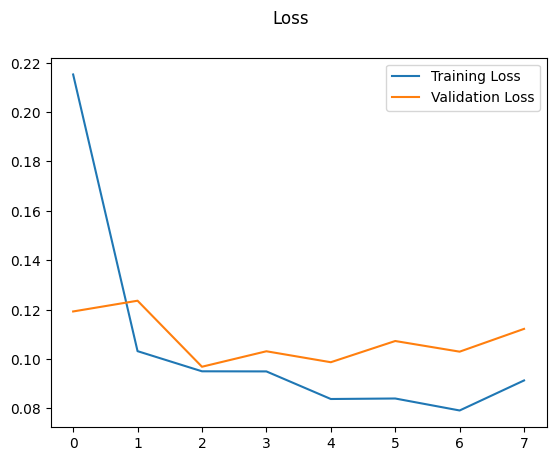

Result:

     Accuracy  F1 Score  Precision    Recall
420  0.980864   0.66155   0.993554  0.662963

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      0.99       270
      Normal       0.98      1.00      0.99     24747
      Replay       0.00      0.00      0.00       485

    accuracy                           0.98     25502
   macro avg       0.66      0.66      0.66     25502
weighted avg       0.96      0.98      0.97     25502



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


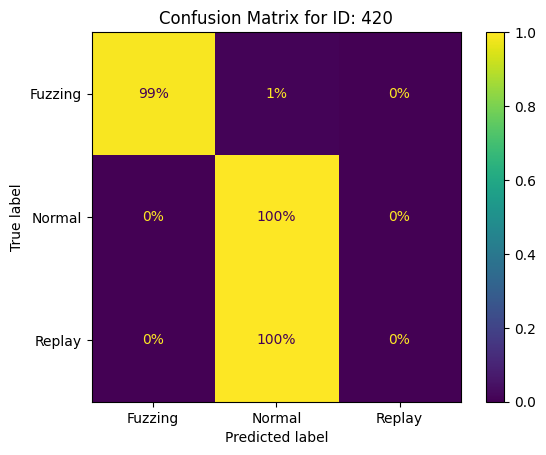

<Figure size 800x600 with 0 Axes>





Processing ID: 421
Epoch 1/100
181/181 [==============================] - 2s 8ms/step - loss: 0.2176 - accuracy: 0.9655 - val_loss: 0.1212 - val_accuracy: 0.9808
Epoch 2/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1088 - accuracy: 0.9858 - val_loss: 0.1100 - val_accuracy: 0.9813
Epoch 3/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1019 - accuracy: 0.9861 - val_loss: 0.1045 - val_accuracy: 0.9815
Epoch 4/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0948 - accuracy: 0.9862 - val_loss: 0.1013 - val_accuracy: 0.9816
Epoch 5/100
181/181 [==============================] - 1s 8ms/step - loss: 0.0925 - accuracy: 0.9863 - val_loss: 0.1013 - val_accuracy: 0.9816
Epoch 6/100
181/181 [==============================] - 2s 10ms/step - loss: 0.0932 - accuracy: 0.9862 - val_loss: 0.0995 - val_accuracy: 0.9816
Epoch 7/100
181/181 [==============================] - 2s 10ms/step - loss: 0.0922 - accuracy: 0.9863 - val_loss: 0.10

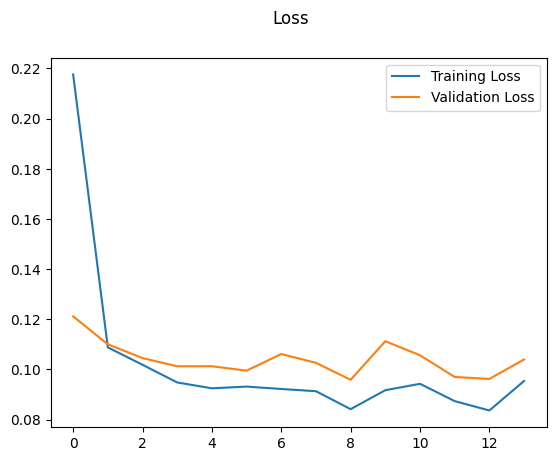

Result:

     Accuracy  F1 Score  Precision    Recall
421  0.980984  0.663431    0.99359  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       284
      Normal       0.98      1.00      0.99     24736
      Replay       0.00      0.00      0.00       485

    accuracy                           0.98     25505
   macro avg       0.66      0.67      0.66     25505
weighted avg       0.96      0.98      0.97     25505



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


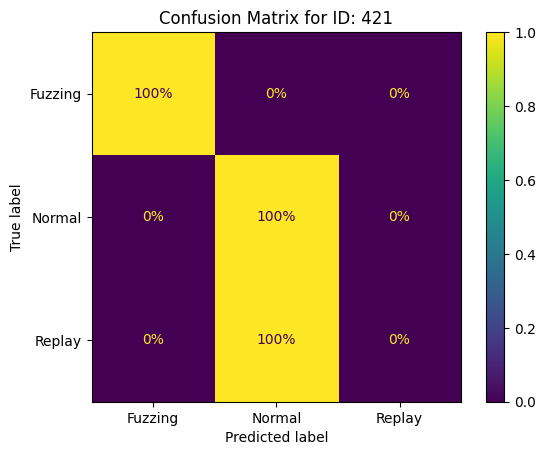

<Figure size 800x600 with 0 Axes>





Processing ID: 389
Epoch 1/100
181/181 [==============================] - 4s 12ms/step - loss: 0.2233 - accuracy: 0.9673 - val_loss: 0.1307 - val_accuracy: 0.9714
Epoch 2/100
181/181 [==============================] - 2s 10ms/step - loss: 0.1169 - accuracy: 0.9848 - val_loss: 0.0990 - val_accuracy: 0.9816
Epoch 3/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1170 - accuracy: 0.9863 - val_loss: 0.1025 - val_accuracy: 0.9816
Epoch 4/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1035 - accuracy: 0.9864 - val_loss: 0.0965 - val_accuracy: 0.9816
Epoch 5/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1006 - accuracy: 0.9864 - val_loss: 0.0967 - val_accuracy: 0.9816
Epoch 6/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1122 - accuracy: 0.9864 - val_loss: 0.0993 - val_accuracy: 0.9816
Epoch 7/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0985 - accuracy: 0.9864 - val_loss: 0.09

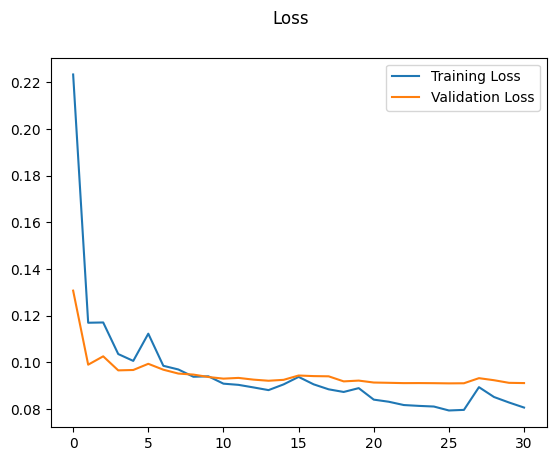

Result:

     Accuracy  F1 Score  Precision    Recall
389  0.980974   0.66343   0.993588  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       276
      Normal       0.98      1.00      0.99     24730
      Replay       0.00      0.00      0.00       485

    accuracy                           0.98     25491
   macro avg       0.66      0.67      0.66     25491
weighted avg       0.96      0.98      0.97     25491



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


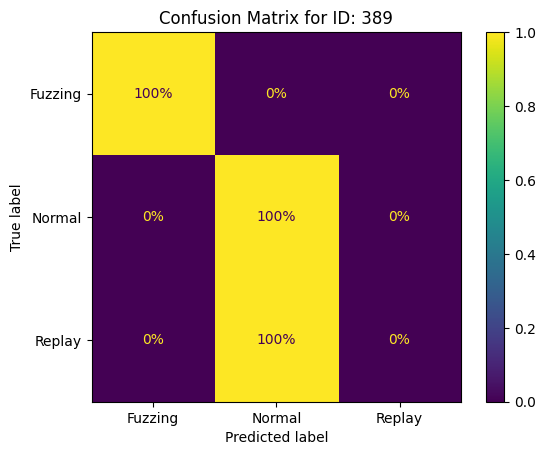

<Figure size 800x600 with 0 Axes>





Processing ID: 386
Epoch 1/100
181/181 [==============================] - 3s 11ms/step - loss: 0.2725 - accuracy: 0.9692 - val_loss: 0.1559 - val_accuracy: 0.9662
Epoch 2/100
181/181 [==============================] - 2s 9ms/step - loss: 0.1229 - accuracy: 0.9798 - val_loss: 0.1037 - val_accuracy: 0.9817
Epoch 3/100
181/181 [==============================] - 2s 10ms/step - loss: 0.0977 - accuracy: 0.9861 - val_loss: 0.0982 - val_accuracy: 0.9817
Epoch 4/100
181/181 [==============================] - 2s 10ms/step - loss: 0.0907 - accuracy: 0.9864 - val_loss: 0.0961 - val_accuracy: 0.9817
Epoch 5/100
181/181 [==============================] - 1s 8ms/step - loss: 0.0862 - accuracy: 0.9863 - val_loss: 0.0940 - val_accuracy: 0.9817
Epoch 6/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0916 - accuracy: 0.9864 - val_loss: 0.0940 - val_accuracy: 0.9817
Epoch 7/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0818 - accuracy: 0.9864 - val_loss: 0.0

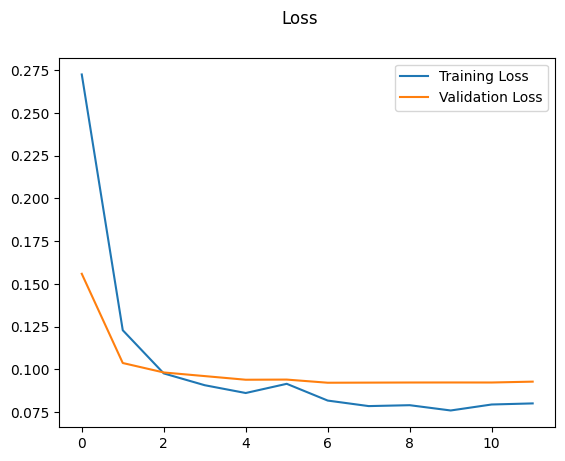

Result:

     Accuracy  F1 Score  Precision    Recall
386  0.980954    0.6628   0.993585  0.665414

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       266
      Normal       0.98      1.00      0.99     24766
      Replay       0.00      0.00      0.00       485

    accuracy                           0.98     25517
   macro avg       0.66      0.67      0.66     25517
weighted avg       0.96      0.98      0.97     25517



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


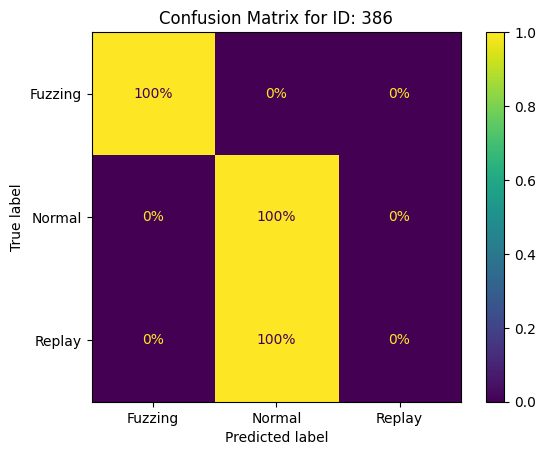

<Figure size 800x600 with 0 Axes>





Processing ID: 492
Epoch 1/100
74/74 [==============================] - 2s 10ms/step - loss: 0.3158 - accuracy: 0.9378 - val_loss: 0.1509 - val_accuracy: 0.9433
Epoch 2/100
74/74 [==============================] - 1s 8ms/step - loss: 0.1041 - accuracy: 0.9824 - val_loss: 0.0940 - val_accuracy: 0.9820
Epoch 3/100
74/74 [==============================] - 1s 9ms/step - loss: 0.0859 - accuracy: 0.9865 - val_loss: 0.0908 - val_accuracy: 0.9820
Epoch 4/100
74/74 [==============================] - 1s 7ms/step - loss: 0.0820 - accuracy: 0.9867 - val_loss: 0.0902 - val_accuracy: 0.9820
Epoch 5/100
74/74 [==============================] - 1s 8ms/step - loss: 0.0832 - accuracy: 0.9867 - val_loss: 0.0899 - val_accuracy: 0.9820
Epoch 6/100
74/74 [==============================] - 1s 7ms/step - loss: 0.0821 - accuracy: 0.9867 - val_loss: 0.0897 - val_accuracy: 0.9820
Epoch 7/100
74/74 [==============================] - 1s 8ms/step - loss: 0.0831 - accuracy: 0.9867 - val_loss: 0.0897 - val_accura

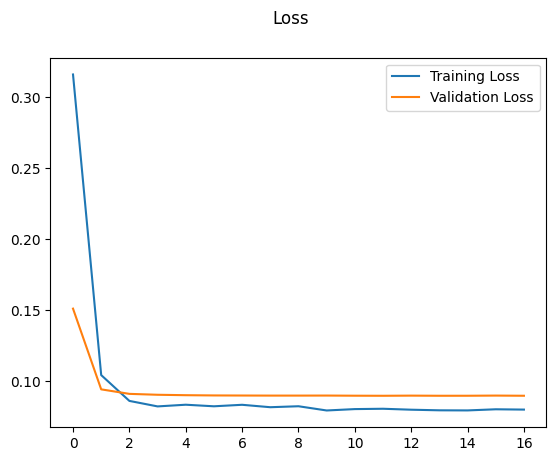

Result:

     Accuracy  F1 Score  Precision    Recall
492  0.981238  0.663432   0.993593  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       247
      Normal       0.98      1.00      0.99      9899
      Replay       0.00      0.00      0.00       194

    accuracy                           0.98     10340
   macro avg       0.66      0.67      0.66     10340
weighted avg       0.96      0.98      0.97     10340



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


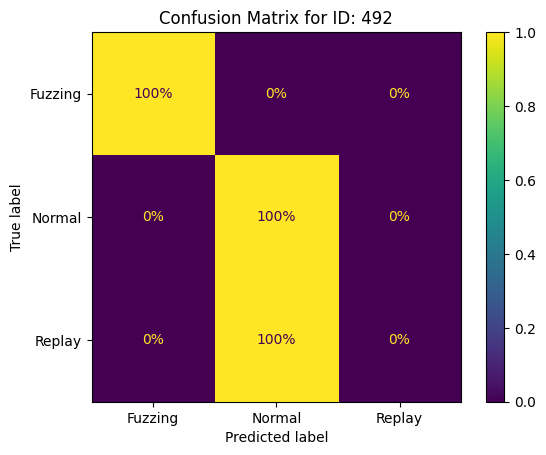

<Figure size 800x600 with 0 Axes>





Processing ID: 391
Epoch 1/100
181/181 [==============================] - 3s 8ms/step - loss: 0.5703 - accuracy: 0.9713 - val_loss: 0.1250 - val_accuracy: 0.9794
Epoch 2/100
181/181 [==============================] - 1s 7ms/step - loss: 0.1024 - accuracy: 0.9855 - val_loss: 0.1011 - val_accuracy: 0.9807
Epoch 3/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0978 - accuracy: 0.9856 - val_loss: 0.1011 - val_accuracy: 0.9807
Epoch 4/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0992 - accuracy: 0.9857 - val_loss: 0.1012 - val_accuracy: 0.9807
Epoch 5/100
181/181 [==============================] - 1s 7ms/step - loss: 0.0948 - accuracy: 0.9857 - val_loss: 0.1002 - val_accuracy: 0.9807
Epoch 6/100
181/181 [==============================] - 2s 9ms/step - loss: 0.0932 - accuracy: 0.9857 - val_loss: 0.0995 - val_accuracy: 0.9807
Epoch 7/100
181/181 [==============================] - 2s 10ms/step - loss: 0.0921 - accuracy: 0.9857 - val_loss: 0.099

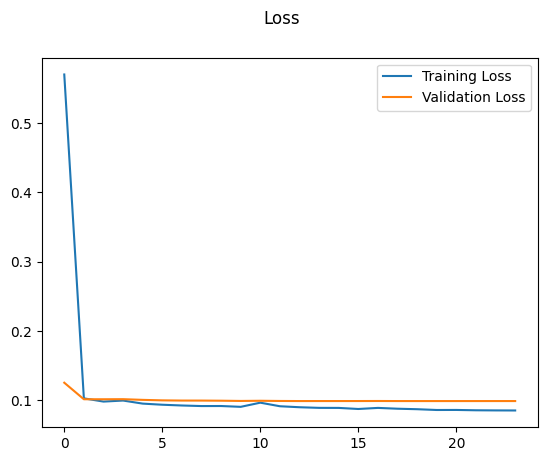

Result:

     Accuracy  F1 Score  Precision    Recall
391   0.98026  0.651247   0.993354  0.643382

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.93      0.96       272
      Normal       0.98      1.00      0.99     24775
      Replay       0.00      0.00      0.00       485

    accuracy                           0.98     25532
   macro avg       0.66      0.64      0.65     25532
weighted avg       0.96      0.98      0.97     25532



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


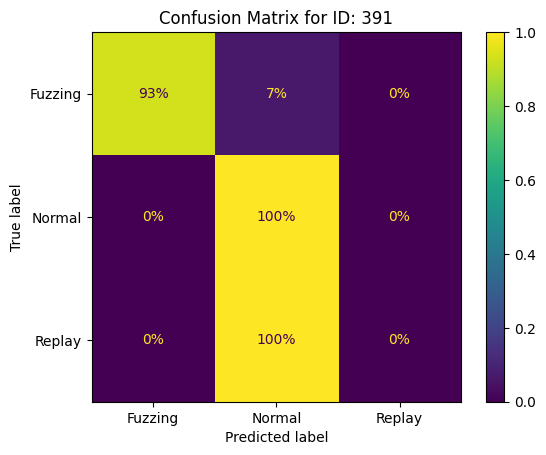

<Figure size 800x600 with 0 Axes>





Processing ID: 485
Epoch 1/100
75/75 [==============================] - 3s 17ms/step - loss: 0.3215 - accuracy: 0.9084 - val_loss: 0.1453 - val_accuracy: 0.9532
Epoch 2/100
75/75 [==============================] - 1s 14ms/step - loss: 0.1046 - accuracy: 0.9823 - val_loss: 0.0896 - val_accuracy: 0.9820
Epoch 3/100
75/75 [==============================] - 1s 14ms/step - loss: 0.0833 - accuracy: 0.9867 - val_loss: 0.0881 - val_accuracy: 0.9820
Epoch 4/100
75/75 [==============================] - 1s 14ms/step - loss: 0.0831 - accuracy: 0.9866 - val_loss: 0.0878 - val_accuracy: 0.9820
Epoch 5/100
75/75 [==============================] - 1s 9ms/step - loss: 0.0802 - accuracy: 0.9867 - val_loss: 0.0876 - val_accuracy: 0.9820
Epoch 6/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0783 - accuracy: 0.9867 - val_loss: 0.0873 - val_accuracy: 0.9820
Epoch 7/100
75/75 [==============================] - 1s 9ms/step - loss: 0.0772 - accuracy: 0.9867 - val_loss: 0.0869 - val_acc

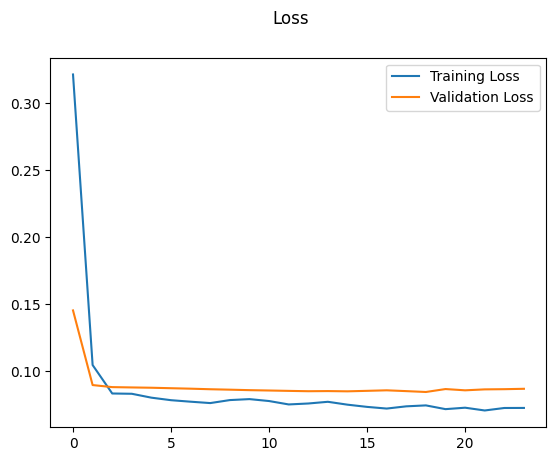

Result:

     Accuracy  F1 Score  Precision    Recall
485  0.981245  0.663431   0.993591  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       254
      Normal       0.98      1.00      0.99      9896
      Replay       0.00      0.00      0.00       194

    accuracy                           0.98     10344
   macro avg       0.66      0.67      0.66     10344
weighted avg       0.96      0.98      0.97     10344



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


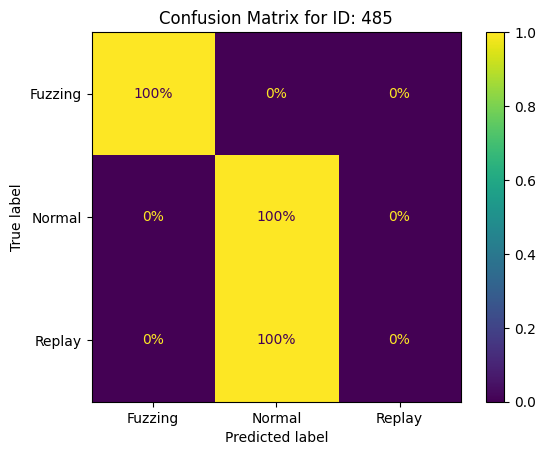

<Figure size 800x600 with 0 Axes>





Processing ID: 490
Epoch 1/100
75/75 [==============================] - 2s 11ms/step - loss: 0.3404 - accuracy: 0.9378 - val_loss: 0.1367 - val_accuracy: 0.9752
Epoch 2/100
75/75 [==============================] - 1s 9ms/step - loss: 0.0963 - accuracy: 0.9861 - val_loss: 0.0917 - val_accuracy: 0.9821
Epoch 3/100
75/75 [==============================] - 1s 9ms/step - loss: 0.0799 - accuracy: 0.9869 - val_loss: 0.0901 - val_accuracy: 0.9821
Epoch 4/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0781 - accuracy: 0.9869 - val_loss: 0.0897 - val_accuracy: 0.9821
Epoch 5/100
75/75 [==============================] - 1s 9ms/step - loss: 0.0769 - accuracy: 0.9869 - val_loss: 0.0896 - val_accuracy: 0.9821
Epoch 6/100
75/75 [==============================] - 1s 8ms/step - loss: 0.0742 - accuracy: 0.9869 - val_loss: 0.0902 - val_accuracy: 0.9821
Epoch 7/100
75/75 [==============================] - 1s 9ms/step - loss: 0.0719 - accuracy: 0.9879 - val_loss: 0.0903 - val_accura

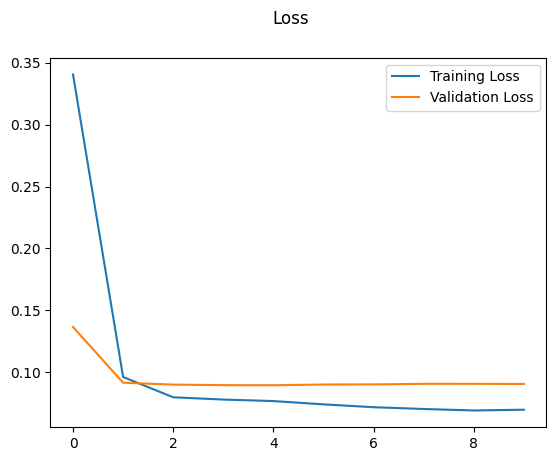

Result:

     Accuracy  F1 Score  Precision    Recall
490  0.981301  0.662842   0.992414  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       273
      Normal       0.98      1.00      0.99      9908
      Replay       0.00      0.00      0.00       194

    accuracy                           0.98     10375
   macro avg       0.66      0.67      0.66     10375
weighted avg       0.96      0.98      0.97     10375



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


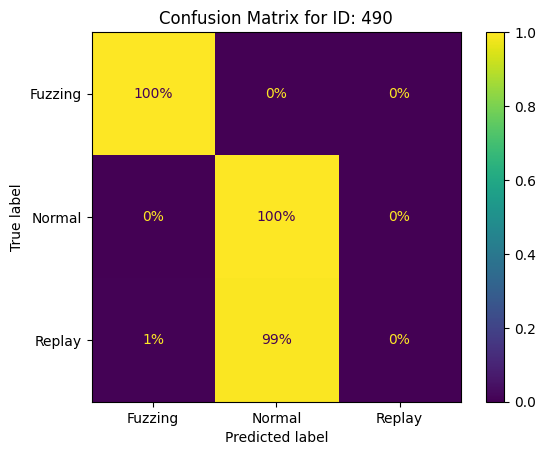

<Figure size 800x600 with 0 Axes>





Processing ID: 593
Epoch 1/100
21/21 [==============================] - 2s 31ms/step - loss: 0.6322 - accuracy: 0.7888 - val_loss: 0.3653 - val_accuracy: 0.8206
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 0.2235 - accuracy: 0.9061 - val_loss: 0.1616 - val_accuracy: 0.9833
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.1000 - accuracy: 0.9879 - val_loss: 0.0988 - val_accuracy: 0.9842
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0759 - accuracy: 0.9883 - val_loss: 0.0852 - val_accuracy: 0.9842
Epoch 5/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0715 - accuracy: 0.9883 - val_loss: 0.0819 - val_accuracy: 0.9842
Epoch 6/100
21/21 [==============================] - 0s 16ms/step - loss: 0.0682 - accuracy: 0.9883 - val_loss: 0.0806 - val_accuracy: 0.9842
Epoch 7/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0662 - accuracy: 0.9883 - val_loss: 0.0803 - val_

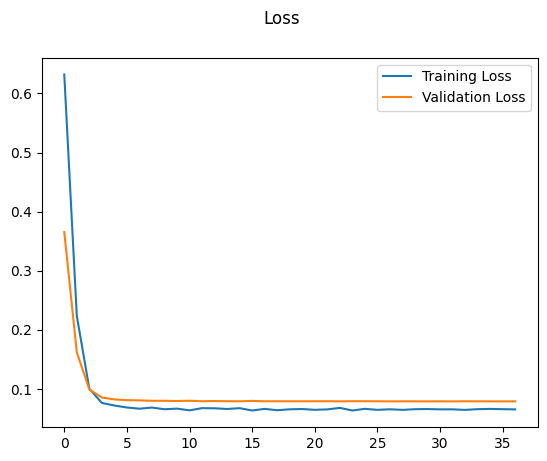

Result:

     Accuracy  F1 Score  Precision    Recall
593  0.261213  0.172878   0.674098  0.395825

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.12      1.00      0.21       264
      Normal       0.91      0.19      0.31      2475
      Replay       0.00      0.00      0.00        48

    accuracy                           0.26      2787
   macro avg       0.34      0.40      0.17      2787
weighted avg       0.82      0.26      0.30      2787



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


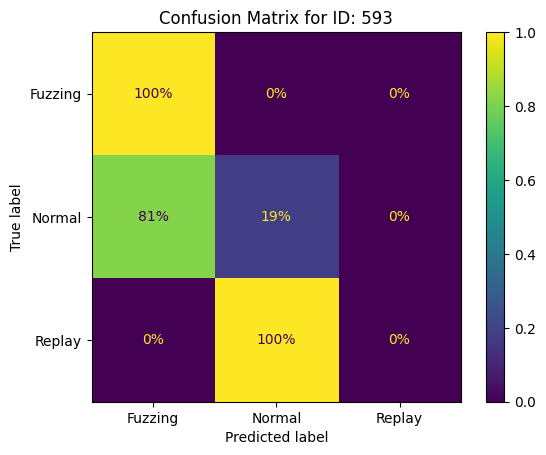

<Figure size 800x600 with 0 Axes>





Processing ID: 484
Epoch 1/100
54/54 [==============================] - 2s 18ms/step - loss: 0.4131 - accuracy: 0.9358 - val_loss: 0.2442 - val_accuracy: 0.9205
Epoch 2/100
54/54 [==============================] - 1s 12ms/step - loss: 0.1981 - accuracy: 0.9390 - val_loss: 0.1539 - val_accuracy: 0.9205
Epoch 3/100
54/54 [==============================] - 1s 11ms/step - loss: 0.1284 - accuracy: 0.9578 - val_loss: 0.1175 - val_accuracy: 0.9691
Epoch 4/100
54/54 [==============================] - 1s 12ms/step - loss: 0.0889 - accuracy: 0.9808 - val_loss: 0.0769 - val_accuracy: 0.9762
Epoch 5/100
54/54 [==============================] - 1s 13ms/step - loss: 0.0685 - accuracy: 0.9840 - val_loss: 0.0645 - val_accuracy: 0.9772
Epoch 6/100
54/54 [==============================] - 1s 11ms/step - loss: 0.0627 - accuracy: 0.9838 - val_loss: 0.0469 - val_accuracy: 0.9803
Epoch 7/100
54/54 [==============================] - 1s 12ms/step - loss: 0.0569 - accuracy: 0.9846 - val_loss: 0.0405 - val_

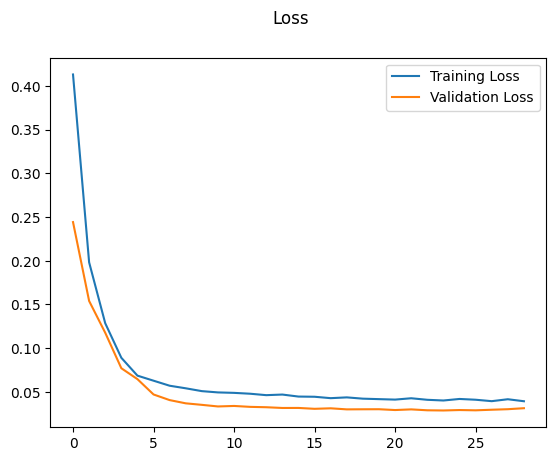

Result:

     Accuracy  F1 Score  Precision   Recall
484  0.911615  0.489359   0.775891  0.63973

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.35      0.99      0.52       281
      Normal       0.98      0.93      0.95      7070
      Replay       0.00      0.00      0.00       139

    accuracy                           0.91      7490
   macro avg       0.44      0.64      0.49      7490
weighted avg       0.94      0.91      0.92      7490



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


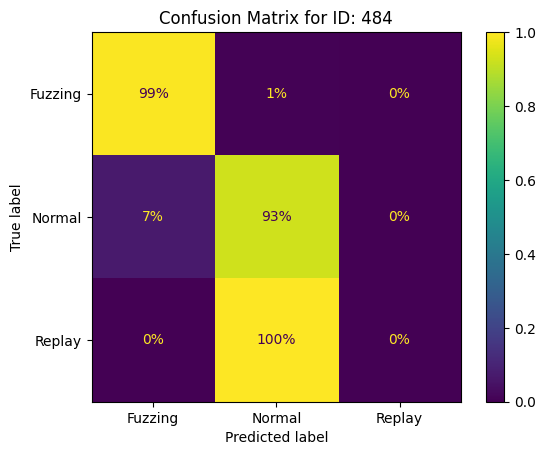

<Figure size 800x600 with 0 Axes>





Processing ID: 48A
Epoch 1/100
75/75 [==============================] - 2s 10ms/step - loss: 0.4071 - accuracy: 0.9166 - val_loss: 0.2271 - val_accuracy: 0.9432
Epoch 2/100
75/75 [==============================] - 1s 8ms/step - loss: 0.1856 - accuracy: 0.9515 - val_loss: 0.1603 - val_accuracy: 0.9693
Epoch 3/100
75/75 [==============================] - 1s 9ms/step - loss: 0.1257 - accuracy: 0.9773 - val_loss: 0.1265 - val_accuracy: 0.9759
Epoch 4/100
75/75 [==============================] - 1s 9ms/step - loss: 0.1096 - accuracy: 0.9802 - val_loss: 0.1204 - val_accuracy: 0.9774
Epoch 5/100
75/75 [==============================] - 1s 8ms/step - loss: 0.1037 - accuracy: 0.9814 - val_loss: 0.1184 - val_accuracy: 0.9781
Epoch 6/100
75/75 [==============================] - 1s 9ms/step - loss: 0.1063 - accuracy: 0.9811 - val_loss: 0.1165 - val_accuracy: 0.9784
Epoch 7/100
75/75 [==============================] - 1s 8ms/step - loss: 0.1037 - accuracy: 0.9815 - val_loss: 0.1168 - val_accura

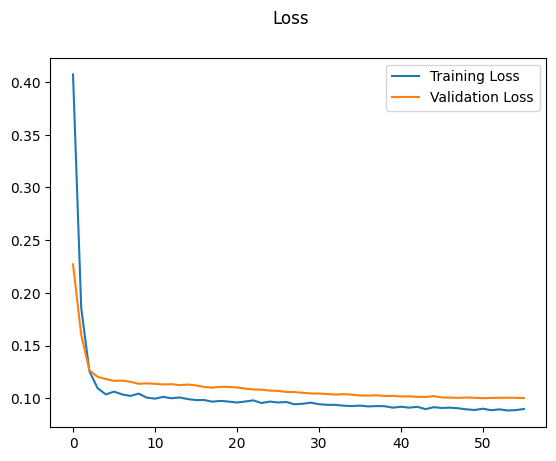

Result:

     Accuracy  F1 Score  Precision    Recall
48A  0.977932  0.640292   0.992469  0.624396

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.87      0.93       276
      Normal       0.98      1.00      0.99      9907
      Replay       0.00      0.00      0.00       194

    accuracy                           0.98     10377
   macro avg       0.66      0.62      0.64     10377
weighted avg       0.96      0.98      0.97     10377



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


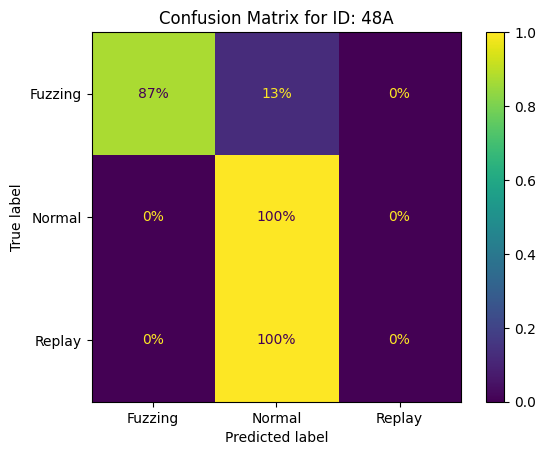

<Figure size 800x600 with 0 Axes>





Processing ID: 50C
Epoch 1/100
39/39 [==============================] - 3s 24ms/step - loss: 0.6010 - accuracy: 0.8630 - val_loss: 0.3062 - val_accuracy: 0.9022
Epoch 2/100
39/39 [==============================] - 1s 13ms/step - loss: 0.1807 - accuracy: 0.9566 - val_loss: 0.1192 - val_accuracy: 0.9805
Epoch 3/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0882 - accuracy: 0.9853 - val_loss: 0.0780 - val_accuracy: 0.9824
Epoch 4/100
39/39 [==============================] - 1s 15ms/step - loss: 0.0754 - accuracy: 0.9870 - val_loss: 0.0783 - val_accuracy: 0.9820
Epoch 5/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0717 - accuracy: 0.9870 - val_loss: 0.0753 - val_accuracy: 0.9824
Epoch 6/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0687 - accuracy: 0.9870 - val_loss: 0.0712 - val_accuracy: 0.9824
Epoch 7/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0685 - accuracy: 0.9870 - val_loss: 0.0709 - val_

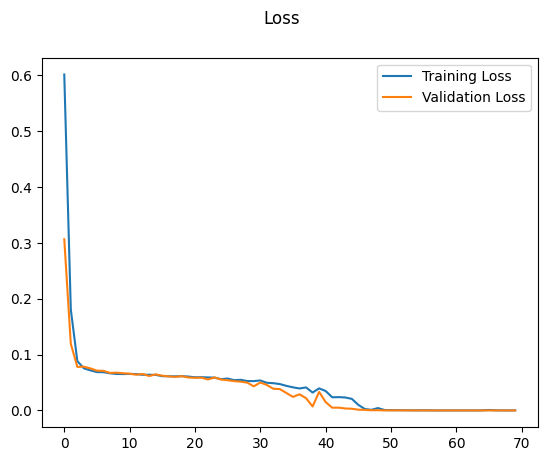

Result:

     Accuracy  F1 Score  Precision    Recall
50C  0.999812  0.999366   0.999933  0.998801

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       278
      Normal       1.00      1.00      1.00      4948
      Replay       1.00      1.00      1.00        97

    accuracy                           1.00      5323
   macro avg       1.00      1.00      1.00      5323
weighted avg       1.00      1.00      1.00      5323



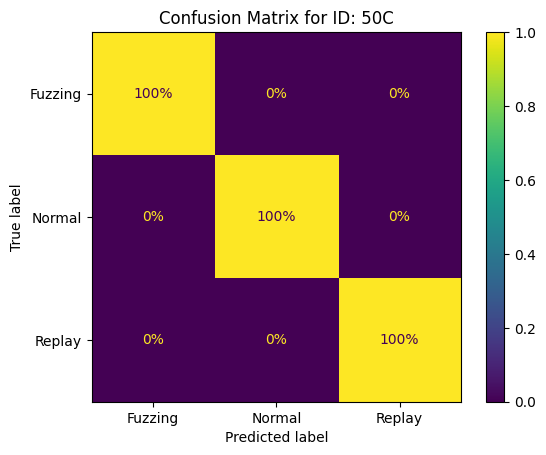

<Figure size 800x600 with 0 Axes>





Processing ID: 58B
Epoch 1/100
75/75 [==============================] - 2s 14ms/step - loss: 0.4588 - accuracy: 0.9402 - val_loss: 0.1449 - val_accuracy: 0.9749
Epoch 2/100
75/75 [==============================] - 1s 15ms/step - loss: 0.0933 - accuracy: 0.9859 - val_loss: 0.0936 - val_accuracy: 0.9821
Epoch 3/100
75/75 [==============================] - 1s 13ms/step - loss: 0.0731 - accuracy: 0.9867 - val_loss: 0.0888 - val_accuracy: 0.9821
Epoch 4/100
75/75 [==============================] - 1s 13ms/step - loss: 0.0732 - accuracy: 0.9867 - val_loss: 0.0867 - val_accuracy: 0.9821
Epoch 5/100
75/75 [==============================] - 1s 14ms/step - loss: 0.0714 - accuracy: 0.9867 - val_loss: 0.0861 - val_accuracy: 0.9821
Epoch 6/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0704 - accuracy: 0.9867 - val_loss: 0.0853 - val_accuracy: 0.9821
Epoch 7/100
75/75 [==============================] - 1s 15ms/step - loss: 0.0691 - accuracy: 0.9867 - val_loss: 0.0857 - val_

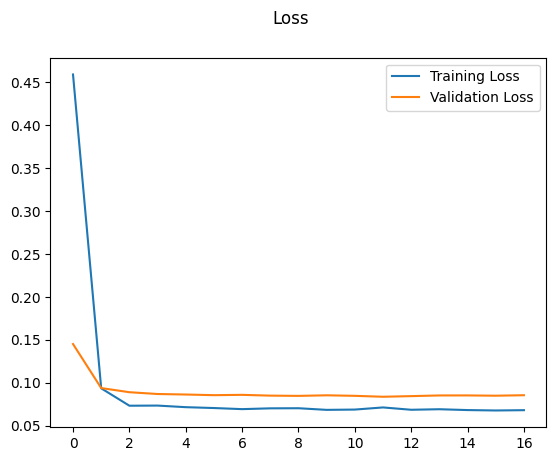

Result:

     Accuracy  F1 Score  Precision    Recall
58B   0.98135  0.663433   0.993595  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       306
      Normal       0.98      1.00      0.99      9902
      Replay       0.00      0.00      0.00       194

    accuracy                           0.98     10402
   macro avg       0.66      0.67      0.66     10402
weighted avg       0.96      0.98      0.97     10402



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


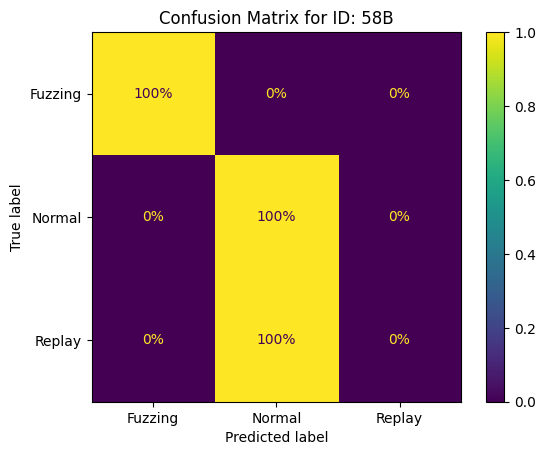

<Figure size 800x600 with 0 Axes>





Processing ID: 436
Epoch 1/100
74/74 [==============================] - 3s 18ms/step - loss: 0.4450 - accuracy: 0.9285 - val_loss: 0.1222 - val_accuracy: 0.9819
Epoch 2/100
74/74 [==============================] - 1s 13ms/step - loss: 0.0876 - accuracy: 0.9866 - val_loss: 0.0944 - val_accuracy: 0.9819
Epoch 3/100
74/74 [==============================] - 1s 12ms/step - loss: 0.0806 - accuracy: 0.9866 - val_loss: 0.0919 - val_accuracy: 0.9819
Epoch 4/100
74/74 [==============================] - 1s 12ms/step - loss: 0.0780 - accuracy: 0.9866 - val_loss: 0.0911 - val_accuracy: 0.9819
Epoch 5/100
74/74 [==============================] - 1s 12ms/step - loss: 0.0774 - accuracy: 0.9866 - val_loss: 0.0908 - val_accuracy: 0.9819
Epoch 6/100
74/74 [==============================] - 1s 13ms/step - loss: 0.0808 - accuracy: 0.9866 - val_loss: 0.0903 - val_accuracy: 0.9819
Epoch 7/100
74/74 [==============================] - 1s 12ms/step - loss: 0.0798 - accuracy: 0.9866 - val_loss: 0.0903 - val_

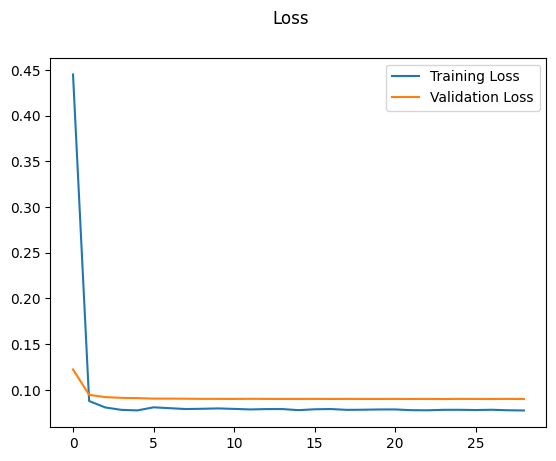

Result:

     Accuracy  F1 Score  Precision    Recall
436  0.981214  0.663418   0.993565  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       279
      Normal       0.98      1.00      0.99      9906
      Replay       0.00      0.00      0.00       195

    accuracy                           0.98     10380
   macro avg       0.66      0.67      0.66     10380
weighted avg       0.96      0.98      0.97     10380



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


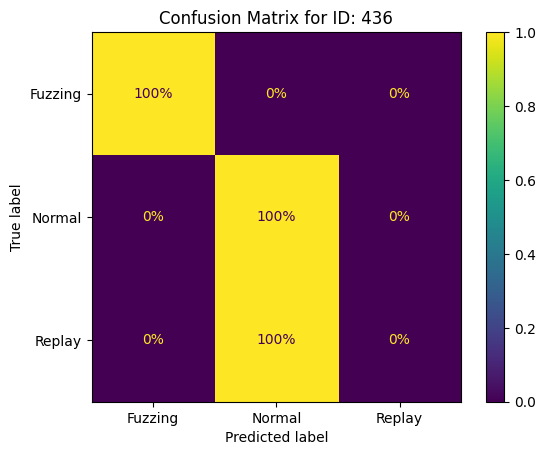

<Figure size 800x600 with 0 Axes>





Processing ID: 541
Epoch 1/100
41/41 [==============================] - 2s 14ms/step - loss: 0.3561 - accuracy: 0.8941 - val_loss: 0.1581 - val_accuracy: 0.9678
Epoch 2/100
41/41 [==============================] - 0s 11ms/step - loss: 0.0991 - accuracy: 0.9864 - val_loss: 0.0908 - val_accuracy: 0.9835
Epoch 3/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0756 - accuracy: 0.9879 - val_loss: 0.0857 - val_accuracy: 0.9835
Epoch 4/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0712 - accuracy: 0.9879 - val_loss: 0.0849 - val_accuracy: 0.9835
Epoch 5/100
41/41 [==============================] - 1s 12ms/step - loss: 0.0717 - accuracy: 0.9879 - val_loss: 0.0841 - val_accuracy: 0.9835
Epoch 6/100
41/41 [==============================] - 0s 10ms/step - loss: 0.0727 - accuracy: 0.9879 - val_loss: 0.0838 - val_accuracy: 0.9835
Epoch 7/100
41/41 [==============================] - 1s 13ms/step - loss: 0.0705 - accuracy: 0.9879 - val_loss: 0.0840 - val_

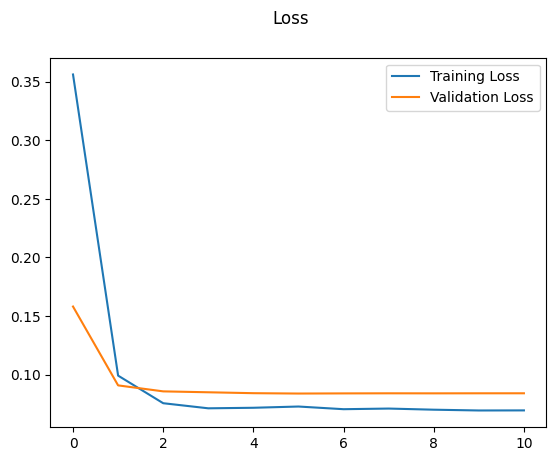

Result:

     Accuracy  F1 Score  Precision    Recall
541  0.982349  0.663551   0.993827  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       260
      Normal       0.98      1.00      0.99      5194
      Replay       0.00      0.00      0.00        98

    accuracy                           0.98      5552
   macro avg       0.66      0.67      0.66      5552
weighted avg       0.97      0.98      0.97      5552



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


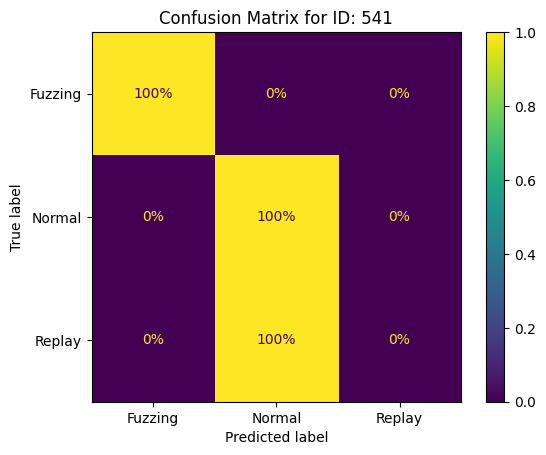

<Figure size 800x600 with 0 Axes>





Processing ID: 507
Epoch 1/100
39/39 [==============================] - 3s 24ms/step - loss: 0.6269 - accuracy: 0.8697 - val_loss: 0.1897 - val_accuracy: 0.9150
Epoch 2/100
39/39 [==============================] - 0s 11ms/step - loss: 0.1130 - accuracy: 0.9782 - val_loss: 0.0998 - val_accuracy: 0.9829
Epoch 3/100
39/39 [==============================] - 0s 12ms/step - loss: 0.0730 - accuracy: 0.9872 - val_loss: 0.0867 - val_accuracy: 0.9829
Epoch 4/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0661 - accuracy: 0.9872 - val_loss: 0.0831 - val_accuracy: 0.9829
Epoch 5/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0660 - accuracy: 0.9872 - val_loss: 0.0816 - val_accuracy: 0.9829
Epoch 6/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0622 - accuracy: 0.9872 - val_loss: 0.0810 - val_accuracy: 0.9829
Epoch 7/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0650 - accuracy: 0.9872 - val_loss: 0.0805 - val_

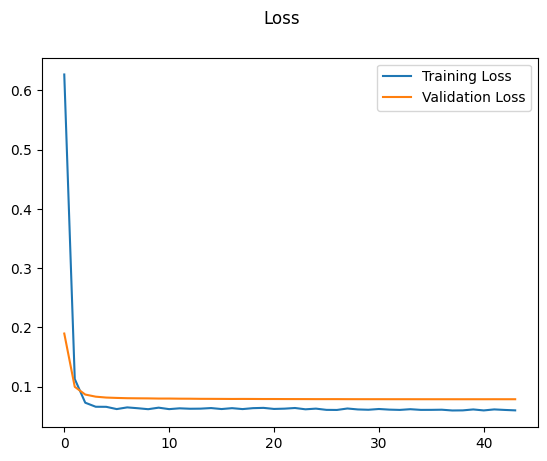

Result:

     Accuracy  F1 Score  Precision    Recall
507  0.981757  0.663431   0.993591  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       272
      Normal       0.98      1.00      0.99      4948
      Replay       0.00      0.00      0.00        97

    accuracy                           0.98      5317
   macro avg       0.66      0.67      0.66      5317
weighted avg       0.96      0.98      0.97      5317



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


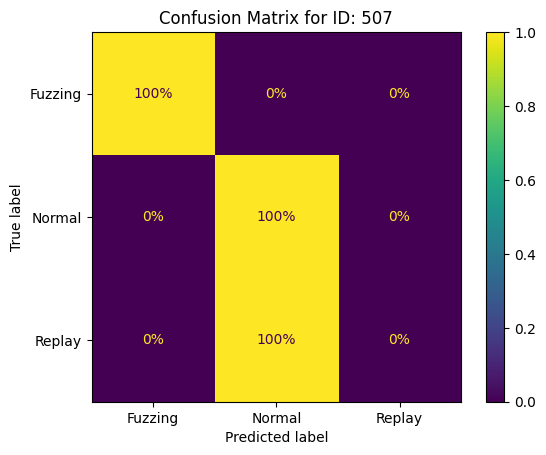

<Figure size 800x600 with 0 Axes>





Processing ID: 4A7
Epoch 1/100
10/10 [==============================] - 2s 54ms/step - loss: 0.9176 - accuracy: 0.7305 - val_loss: 0.7251 - val_accuracy: 0.6710
Epoch 2/100
10/10 [==============================] - 0s 24ms/step - loss: 0.5512 - accuracy: 0.7528 - val_loss: 0.4227 - val_accuracy: 0.8253
Epoch 3/100
10/10 [==============================] - 0s 23ms/step - loss: 0.3154 - accuracy: 0.8740 - val_loss: 0.2312 - val_accuracy: 0.9870
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1700 - accuracy: 0.9888 - val_loss: 0.1350 - val_accuracy: 0.9870
Epoch 5/100
10/10 [==============================] - 0s 25ms/step - loss: 0.1033 - accuracy: 0.9896 - val_loss: 0.0992 - val_accuracy: 0.9870
Epoch 6/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0748 - accuracy: 0.9896 - val_loss: 0.0838 - val_accuracy: 0.9870
Epoch 7/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0706 - accuracy: 0.9896 - val_loss: 0.0726 - val_

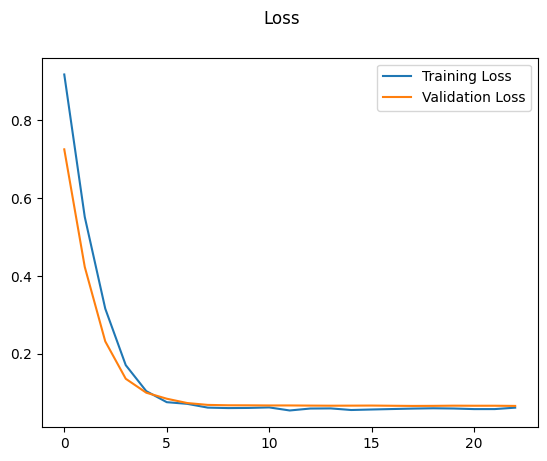

Result:

     Accuracy  F1 Score  Precision    Recall
4A7   0.98424  0.663337   0.993406  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       258
      Normal       0.98      1.00      0.99       991
      Replay       0.00      0.00      0.00        20

    accuracy                           0.98      1269
   macro avg       0.66      0.67      0.66      1269
weighted avg       0.97      0.98      0.98      1269



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


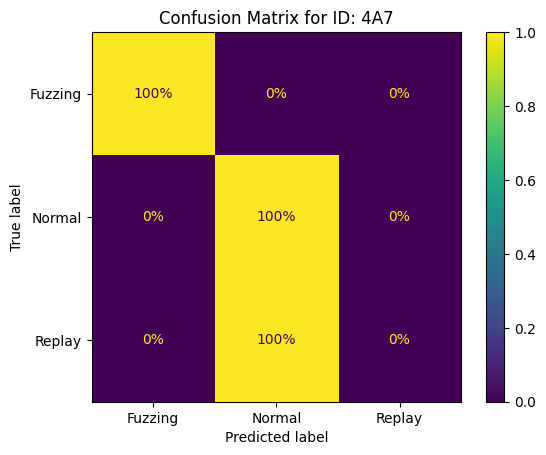

<Figure size 800x600 with 0 Axes>





Processing ID: 520
Epoch 1/100
39/39 [==============================] - 2s 16ms/step - loss: 0.9850 - accuracy: 0.9584 - val_loss: 0.6160 - val_accuracy: 0.9825
Epoch 2/100
39/39 [==============================] - 0s 10ms/step - loss: 0.2062 - accuracy: 0.9809 - val_loss: 0.1150 - val_accuracy: 0.9825
Epoch 3/100
39/39 [==============================] - 0s 12ms/step - loss: 0.0829 - accuracy: 0.9870 - val_loss: 0.0933 - val_accuracy: 0.9825
Epoch 4/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0763 - accuracy: 0.9870 - val_loss: 0.0893 - val_accuracy: 0.9825
Epoch 5/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0742 - accuracy: 0.9870 - val_loss: 0.0879 - val_accuracy: 0.9825
Epoch 6/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0742 - accuracy: 0.9870 - val_loss: 0.0871 - val_accuracy: 0.9825
Epoch 7/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0754 - accuracy: 0.9870 - val_loss: 0.0864 - val_

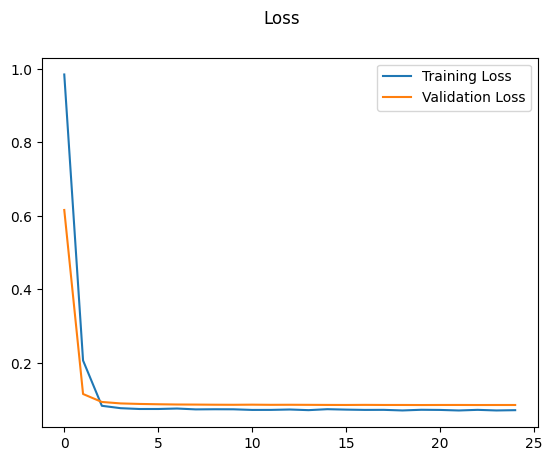

Result:

     Accuracy  F1 Score  Precision    Recall
520  0.981708  0.663417   0.993564  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       279
      Normal       0.98      1.00      0.99      4927
      Replay       0.00      0.00      0.00        97

    accuracy                           0.98      5303
   macro avg       0.66      0.67      0.66      5303
weighted avg       0.96      0.98      0.97      5303



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


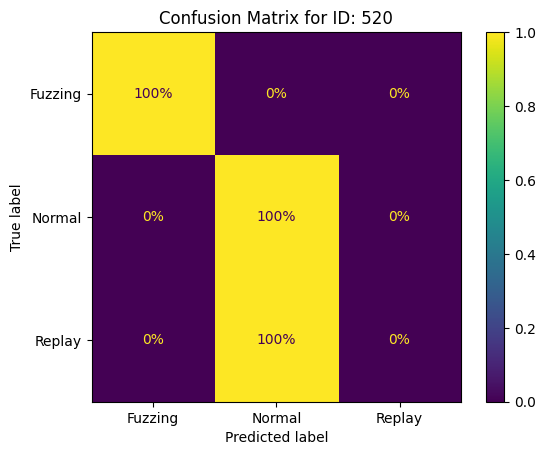

<Figure size 800x600 with 0 Axes>





Processing ID: 53E
Epoch 1/100
39/39 [==============================] - 2s 18ms/step - loss: 0.5529 - accuracy: 0.8729 - val_loss: 0.2603 - val_accuracy: 0.8987
Epoch 2/100
39/39 [==============================] - 1s 14ms/step - loss: 0.1675 - accuracy: 0.9389 - val_loss: 0.1593 - val_accuracy: 0.9777
Epoch 3/100
39/39 [==============================] - 0s 12ms/step - loss: 0.0949 - accuracy: 0.9858 - val_loss: 0.0966 - val_accuracy: 0.9820
Epoch 4/100
39/39 [==============================] - 0s 12ms/step - loss: 0.0712 - accuracy: 0.9868 - val_loss: 0.0910 - val_accuracy: 0.9825
Epoch 5/100
39/39 [==============================] - 0s 12ms/step - loss: 0.0708 - accuracy: 0.9870 - val_loss: 0.0893 - val_accuracy: 0.9825
Epoch 6/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0689 - accuracy: 0.9872 - val_loss: 0.0884 - val_accuracy: 0.9825
Epoch 7/100
39/39 [==============================] - 1s 14ms/step - loss: 0.0680 - accuracy: 0.9872 - val_loss: 0.0878 - val_

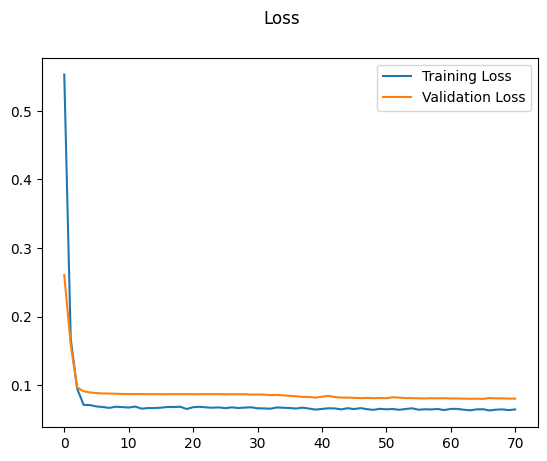

Result:

     Accuracy  F1 Score  Precision    Recall
53E  0.981815  0.663434   0.993596  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       285
      Normal       0.98      1.00      0.99      4952
      Replay       0.00      0.00      0.00        97

    accuracy                           0.98      5334
   macro avg       0.66      0.67      0.66      5334
weighted avg       0.96      0.98      0.97      5334



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


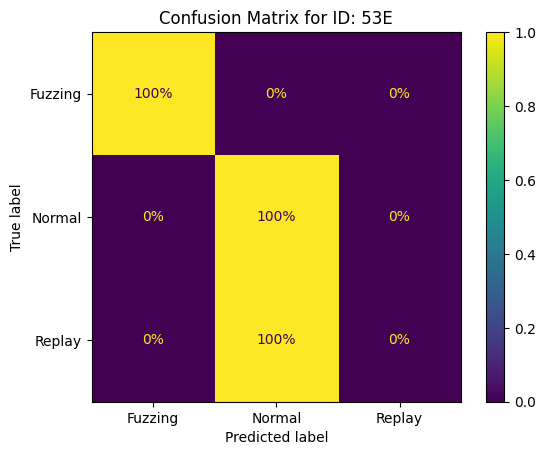

<Figure size 800x600 with 0 Axes>





Processing ID: 495
Epoch 1/100
38/38 [==============================] - 2s 15ms/step - loss: 0.5896 - accuracy: 0.9092 - val_loss: 0.4119 - val_accuracy: 0.9078
Epoch 2/100
38/38 [==============================] - 0s 10ms/step - loss: 0.3275 - accuracy: 0.9275 - val_loss: 0.3706 - val_accuracy: 0.9078
Epoch 3/100
38/38 [==============================] - 0s 10ms/step - loss: 0.3253 - accuracy: 0.9275 - val_loss: 0.3693 - val_accuracy: 0.9078
Epoch 4/100
38/38 [==============================] - 0s 10ms/step - loss: 0.3254 - accuracy: 0.9275 - val_loss: 0.3674 - val_accuracy: 0.9078
Epoch 5/100
38/38 [==============================] - 0s 10ms/step - loss: 0.3252 - accuracy: 0.9275 - val_loss: 0.3652 - val_accuracy: 0.9078
Epoch 6/100
38/38 [==============================] - 0s 11ms/step - loss: 0.3208 - accuracy: 0.9275 - val_loss: 0.3627 - val_accuracy: 0.9078
Epoch 7/100
38/38 [==============================] - 0s 11ms/step - loss: 0.3169 - accuracy: 0.9275 - val_loss: 0.3609 - val_

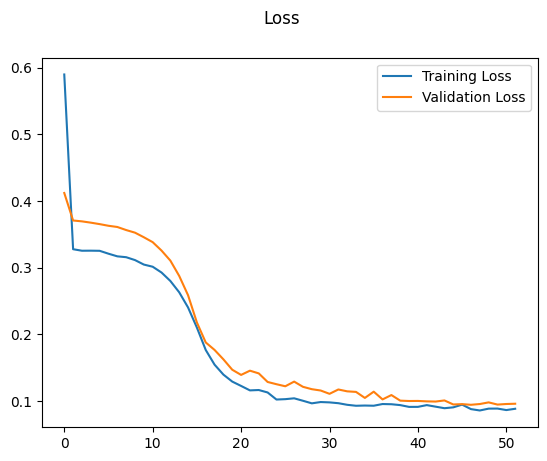

Result:

     Accuracy  F1 Score  Precision    Recall
495  0.978635  0.651789   0.992552  0.645161

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.94      0.97       248
      Normal       0.98      1.00      0.99      4944
      Replay       0.00      0.00      0.00        97

    accuracy                           0.98      5289
   macro avg       0.66      0.65      0.65      5289
weighted avg       0.96      0.98      0.97      5289



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


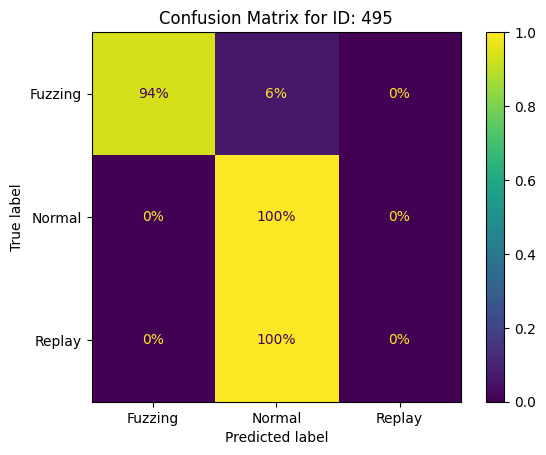

<Figure size 800x600 with 0 Axes>





Processing ID: 500
Epoch 1/100
39/39 [==============================] - 2s 15ms/step - loss: 0.6712 - accuracy: 0.8903 - val_loss: 0.3473 - val_accuracy: 0.9052
Epoch 2/100
39/39 [==============================] - 0s 10ms/step - loss: 0.2097 - accuracy: 0.9474 - val_loss: 0.1776 - val_accuracy: 0.9698
Epoch 3/100
39/39 [==============================] - 0s 10ms/step - loss: 0.1234 - accuracy: 0.9809 - val_loss: 0.1273 - val_accuracy: 0.9770
Epoch 4/100
39/39 [==============================] - 0s 10ms/step - loss: 0.1050 - accuracy: 0.9838 - val_loss: 0.1137 - val_accuracy: 0.9799
Epoch 5/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0919 - accuracy: 0.9846 - val_loss: 0.1097 - val_accuracy: 0.9799
Epoch 6/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0919 - accuracy: 0.9848 - val_loss: 0.1062 - val_accuracy: 0.9799
Epoch 7/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0903 - accuracy: 0.9850 - val_loss: 0.1039 - val_

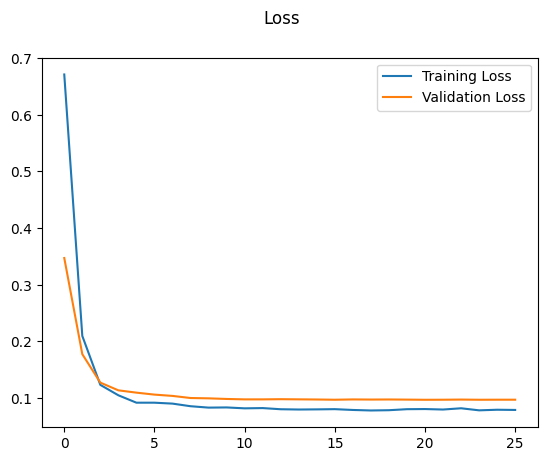

Result:

     Accuracy  F1 Score  Precision    Recall
500  0.979741  0.656729   0.992867  0.654237

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.96      0.98       295
      Normal       0.98      1.00      0.99      4939
      Replay       0.00      0.00      0.00        97

    accuracy                           0.98      5331
   macro avg       0.66      0.65      0.66      5331
weighted avg       0.96      0.98      0.97      5331



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


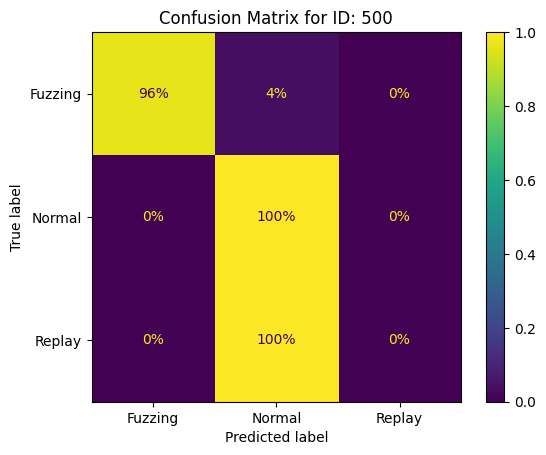

<Figure size 800x600 with 0 Axes>





Processing ID: 483
Epoch 1/100
22/22 [==============================] - 2s 23ms/step - loss: 0.9110 - accuracy: 0.7638 - val_loss: 0.6395 - val_accuracy: 0.8424
Epoch 2/100
22/22 [==============================] - 0s 11ms/step - loss: 0.4270 - accuracy: 0.8730 - val_loss: 0.4960 - val_accuracy: 0.8424
Epoch 3/100
22/22 [==============================] - 0s 12ms/step - loss: 0.3880 - accuracy: 0.8730 - val_loss: 0.4565 - val_accuracy: 0.8424
Epoch 4/100
22/22 [==============================] - 0s 11ms/step - loss: 0.3555 - accuracy: 0.8738 - val_loss: 0.4277 - val_accuracy: 0.8475
Epoch 5/100
22/22 [==============================] - 0s 12ms/step - loss: 0.3368 - accuracy: 0.8926 - val_loss: 0.3941 - val_accuracy: 0.8932
Epoch 6/100
22/22 [==============================] - 0s 15ms/step - loss: 0.3071 - accuracy: 0.9188 - val_loss: 0.3584 - val_accuracy: 0.9035
Epoch 7/100
22/22 [==============================] - 0s 11ms/step - loss: 0.2819 - accuracy: 0.9273 - val_loss: 0.3231 - val_

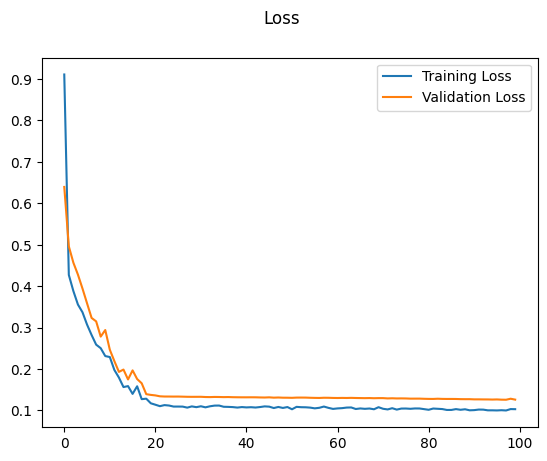

Result:

     Accuracy  F1 Score  Precision    Recall
483  0.973861  0.646775   0.990387  0.637931

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.91      0.95       290
      Normal       0.97      1.00      0.99      2492
      Replay       0.00      0.00      0.00        49

    accuracy                           0.97      2831
   macro avg       0.66      0.64      0.65      2831
weighted avg       0.96      0.97      0.97      2831



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


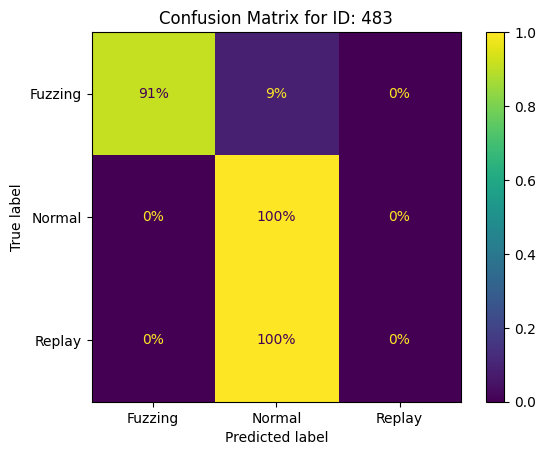

<Figure size 800x600 with 0 Axes>





Processing ID: 4A2
Epoch 1/100
11/11 [==============================] - 2s 60ms/step - loss: 1.0423 - accuracy: 0.8098 - val_loss: 0.9319 - val_accuracy: 0.9873
Epoch 2/100
11/11 [==============================] - 0s 15ms/step - loss: 0.8586 - accuracy: 0.9899 - val_loss: 0.6561 - val_accuracy: 0.9873
Epoch 3/100
11/11 [==============================] - 0s 16ms/step - loss: 0.5560 - accuracy: 0.9899 - val_loss: 0.2806 - val_accuracy: 0.9873
Epoch 4/100
11/11 [==============================] - 0s 18ms/step - loss: 0.2015 - accuracy: 0.9891 - val_loss: 0.0817 - val_accuracy: 0.9873
Epoch 5/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0712 - accuracy: 0.9891 - val_loss: 0.0822 - val_accuracy: 0.9873
Epoch 6/100
11/11 [==============================] - 0s 13ms/step - loss: 0.0746 - accuracy: 0.9899 - val_loss: 0.0831 - val_accuracy: 0.9873
Epoch 7/100
11/11 [==============================] - 0s 15ms/step - loss: 0.0702 - accuracy: 0.9899 - val_loss: 0.0759 - val_

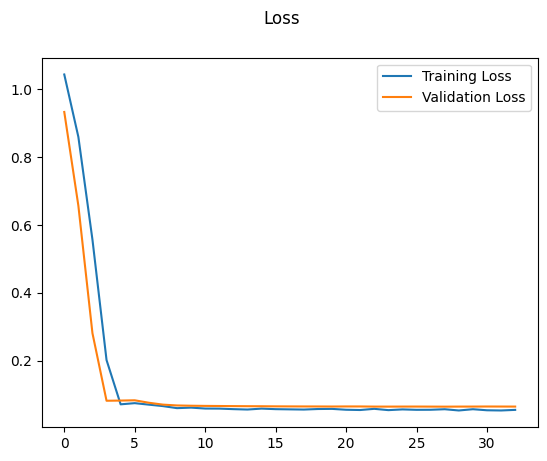

Result:

     Accuracy  F1 Score  Precision    Recall
4A2  0.984472  0.663327   0.993386  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       280
      Normal       0.98      1.00      0.99       988
      Replay       0.00      0.00      0.00        20

    accuracy                           0.98      1288
   macro avg       0.66      0.67      0.66      1288
weighted avg       0.97      0.98      0.98      1288



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


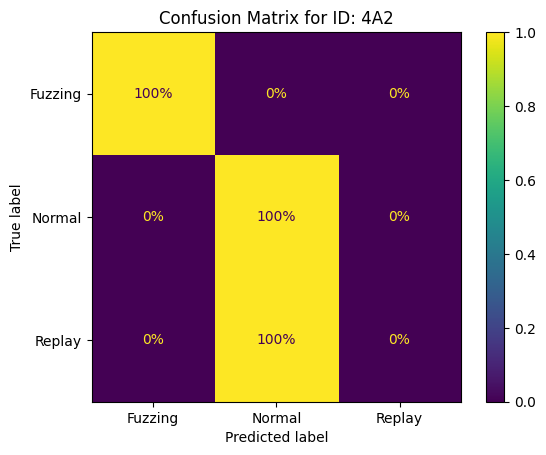

<Figure size 800x600 with 0 Axes>





Processing ID: 50A
Epoch 1/100
26/26 [==============================] - 2s 25ms/step - loss: 0.5433 - accuracy: 0.8777 - val_loss: 0.3369 - val_accuracy: 0.8631
Epoch 2/100
26/26 [==============================] - 0s 12ms/step - loss: 0.2267 - accuracy: 0.9230 - val_loss: 0.1718 - val_accuracy: 0.9689
Epoch 3/100
26/26 [==============================] - 0s 11ms/step - loss: 0.1189 - accuracy: 0.9811 - val_loss: 0.0966 - val_accuracy: 0.9812
Epoch 4/100
26/26 [==============================] - 0s 11ms/step - loss: 0.0809 - accuracy: 0.9863 - val_loss: 0.0830 - val_accuracy: 0.9826
Epoch 5/100
26/26 [==============================] - 0s 16ms/step - loss: 0.0738 - accuracy: 0.9873 - val_loss: 0.0791 - val_accuracy: 0.9833
Epoch 6/100
26/26 [==============================] - 0s 15ms/step - loss: 0.0689 - accuracy: 0.9879 - val_loss: 0.0789 - val_accuracy: 0.9833
Epoch 7/100
26/26 [==============================] - 0s 14ms/step - loss: 0.0697 - accuracy: 0.9882 - val_loss: 0.0787 - val_

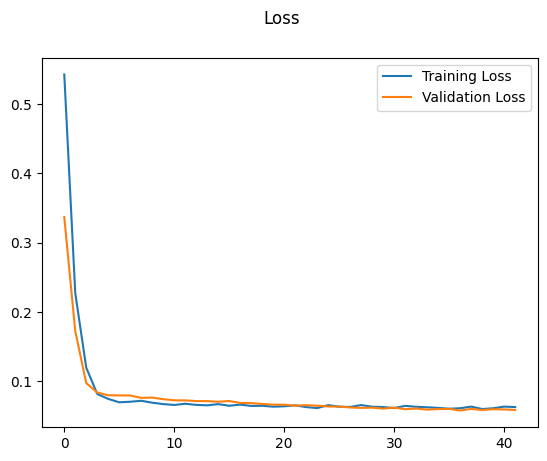

Result:

     Accuracy  F1 Score  Precision    Recall
50A  0.985307  0.662709   0.994711  0.664093

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.99      1.00       259
      Normal       0.98      1.00      0.99      3163
      Replay       0.00      0.00      0.00        49

    accuracy                           0.99      3471
   macro avg       0.66      0.66      0.66      3471
weighted avg       0.97      0.99      0.98      3471



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


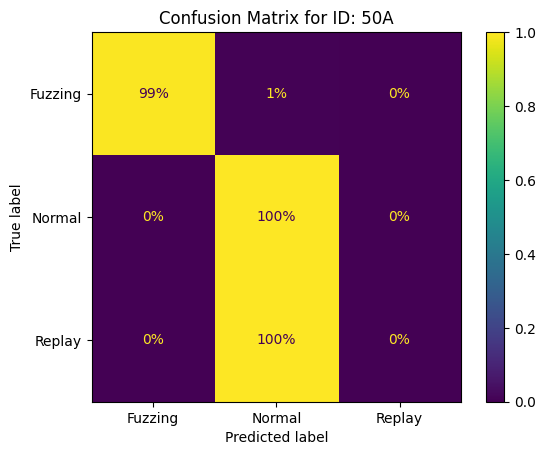

<Figure size 800x600 with 0 Axes>





Processing ID: 043
Epoch 1/100
10/10 [==============================] - 2s 48ms/step - loss: 0.9206 - accuracy: 0.6147 - val_loss: 0.6053 - val_accuracy: 0.6532
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 0.5340 - accuracy: 0.5931 - val_loss: 0.3624 - val_accuracy: 0.6532
Epoch 3/100
10/10 [==============================] - 0s 16ms/step - loss: 0.3931 - accuracy: 0.7576 - val_loss: 0.2757 - val_accuracy: 0.9919
Epoch 4/100
10/10 [==============================] - 0s 16ms/step - loss: 0.2840 - accuracy: 0.9939 - val_loss: 0.1874 - val_accuracy: 0.9919
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1675 - accuracy: 0.9939 - val_loss: 0.0985 - val_accuracy: 0.9919
Epoch 6/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0772 - accuracy: 0.9939 - val_loss: 0.0550 - val_accuracy: 0.9919
Epoch 7/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0410 - accuracy: 0.9939 - val_loss: 0.0438 - val_

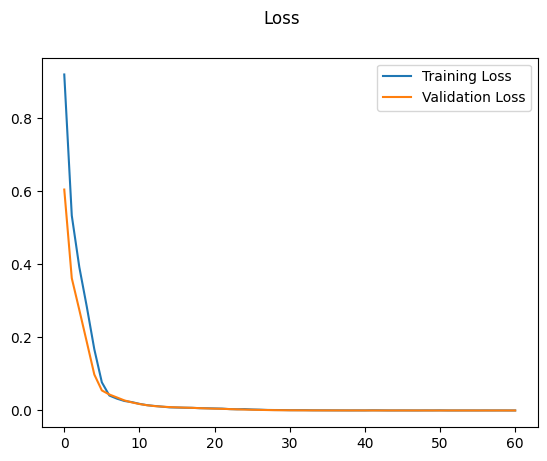

Result:

     Accuracy  F1 Score  Precision    Recall
043  0.994214  0.897992   0.996008  0.846154

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       529
      Normal       0.99      1.00      0.99       495
      Replay       1.00      0.54      0.70        13

    accuracy                           0.99      1037
   macro avg       1.00      0.85      0.90      1037
weighted avg       0.99      0.99      0.99      1037



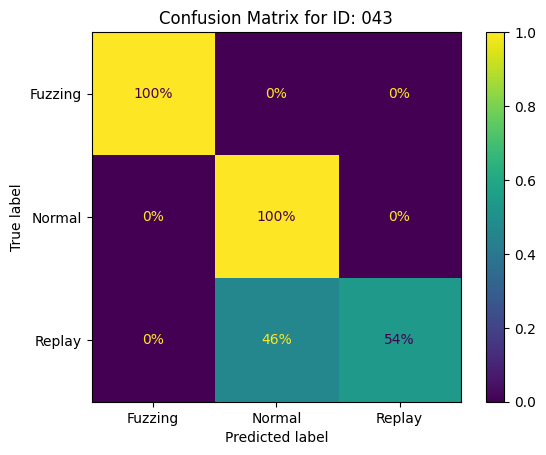

<Figure size 800x600 with 0 Axes>





Processing ID: 544
Epoch 1/100
21/21 [==============================] - 3s 27ms/step - loss: 0.7391 - accuracy: 0.6911 - val_loss: 0.4037 - val_accuracy: 0.8374
Epoch 2/100
21/21 [==============================] - 0s 13ms/step - loss: 0.3677 - accuracy: 0.8674 - val_loss: 0.3683 - val_accuracy: 0.8374
Epoch 3/100
21/21 [==============================] - 0s 12ms/step - loss: 0.3058 - accuracy: 0.8674 - val_loss: 0.3253 - val_accuracy: 0.8374
Epoch 4/100
21/21 [==============================] - 0s 11ms/step - loss: 0.2547 - accuracy: 0.9049 - val_loss: 0.2531 - val_accuracy: 0.9410
Epoch 5/100
21/21 [==============================] - 0s 13ms/step - loss: 0.1872 - accuracy: 0.9651 - val_loss: 0.1775 - val_accuracy: 0.9660
Epoch 6/100
21/21 [==============================] - 0s 12ms/step - loss: 0.1303 - accuracy: 0.9782 - val_loss: 0.1402 - val_accuracy: 0.9714
Epoch 7/100
21/21 [==============================] - 0s 14ms/step - loss: 0.1066 - accuracy: 0.9805 - val_loss: 0.1195 - val_

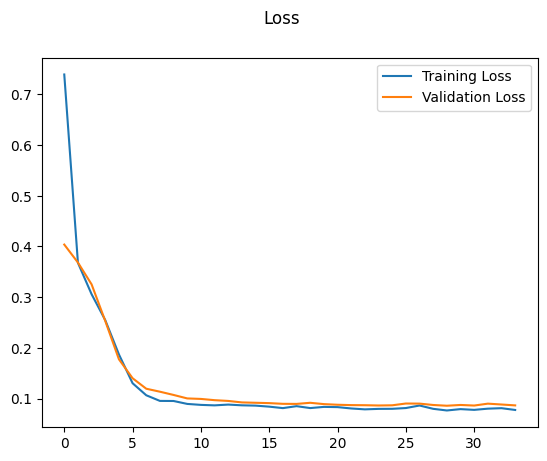

Result:

     Accuracy  F1 Score  Precision   Recall
544  0.979555   0.65785   0.992478  0.65679

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      0.97      0.98       270
      Normal       0.98      1.00      0.99      2469
      Replay       0.00      0.00      0.00        49

    accuracy                           0.98      2788
   macro avg       0.66      0.66      0.66      2788
weighted avg       0.96      0.98      0.97      2788



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


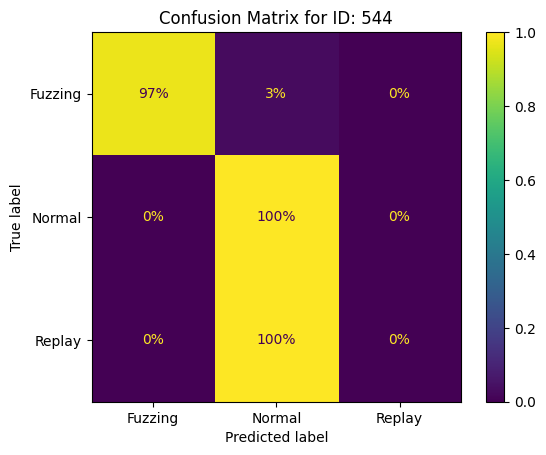

<Figure size 800x600 with 0 Axes>





Processing ID: 559
Epoch 1/100
21/21 [==============================] - 2s 31ms/step - loss: 1.0051 - accuracy: 0.9273 - val_loss: 0.8473 - val_accuracy: 0.9840
Epoch 2/100
21/21 [==============================] - 0s 16ms/step - loss: 0.6499 - accuracy: 0.9878 - val_loss: 0.2656 - val_accuracy: 0.9840
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 0.1527 - accuracy: 0.9825 - val_loss: 0.1191 - val_accuracy: 0.9840
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0948 - accuracy: 0.9878 - val_loss: 0.1116 - val_accuracy: 0.9840
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0888 - accuracy: 0.9878 - val_loss: 0.0986 - val_accuracy: 0.9840
Epoch 6/100
21/21 [==============================] - 0s 16ms/step - loss: 0.0796 - accuracy: 0.9878 - val_loss: 0.0928 - val_accuracy: 0.9840
Epoch 7/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0737 - accuracy: 0.9878 - val_loss: 0.0890 - val_

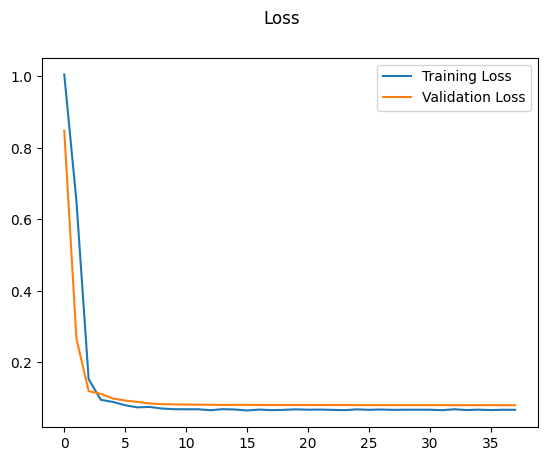

Result:

     Accuracy  F1 Score  Precision    Recall
559  0.982285  0.663388   0.993506  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       251
      Normal       0.98      1.00      0.99      2466
      Replay       0.00      0.00      0.00        49

    accuracy                           0.98      2766
   macro avg       0.66      0.67      0.66      2766
weighted avg       0.96      0.98      0.97      2766



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


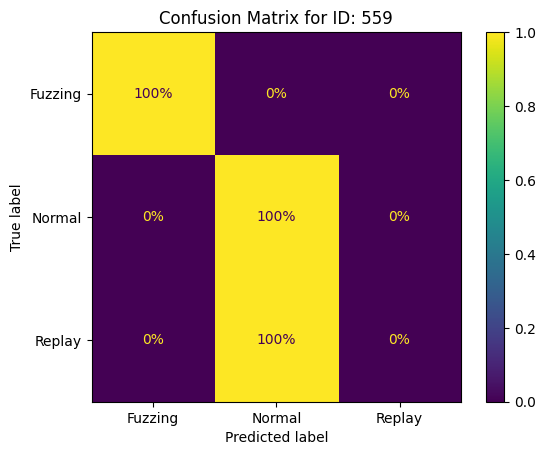

<Figure size 800x600 with 0 Axes>





Processing ID: 410
Epoch 1/100
21/21 [==============================] - 2s 21ms/step - loss: 0.8146 - accuracy: 0.8267 - val_loss: 0.4096 - val_accuracy: 0.8857
Epoch 2/100
21/21 [==============================] - 0s 12ms/step - loss: 0.2166 - accuracy: 0.9472 - val_loss: 0.1263 - val_accuracy: 0.9841
Epoch 3/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0972 - accuracy: 0.9878 - val_loss: 0.1007 - val_accuracy: 0.9841
Epoch 4/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0793 - accuracy: 0.9878 - val_loss: 0.0869 - val_accuracy: 0.9841
Epoch 5/100
21/21 [==============================] - 0s 14ms/step - loss: 0.0677 - accuracy: 0.9878 - val_loss: 0.0834 - val_accuracy: 0.9841
Epoch 6/100
21/21 [==============================] - 0s 13ms/step - loss: 0.0694 - accuracy: 0.9878 - val_loss: 0.0814 - val_accuracy: 0.9841
Epoch 7/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0685 - accuracy: 0.9878 - val_loss: 0.0807 - val_

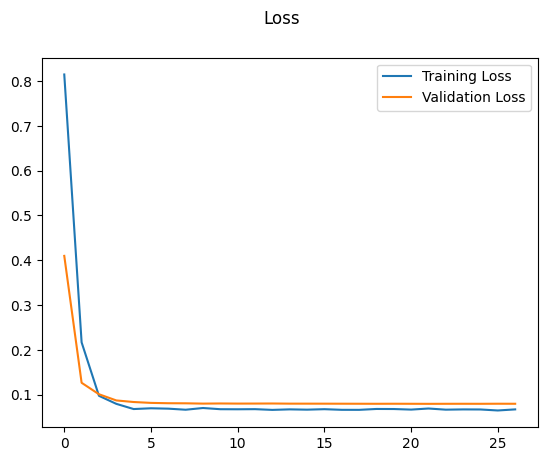

Result:

     Accuracy  F1 Score  Precision    Recall
410  0.982655  0.663401   0.993531  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       300
      Normal       0.98      1.00      0.99      2476
      Replay       0.00      0.00      0.00        49

    accuracy                           0.98      2825
   macro avg       0.66      0.67      0.66      2825
weighted avg       0.97      0.98      0.97      2825



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


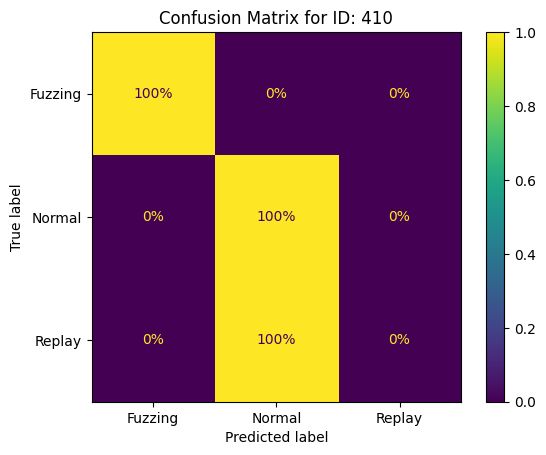

<Figure size 800x600 with 0 Axes>





Processing ID: 07F
Epoch 1/100
7/7 [==============================] - 2s 65ms/step - loss: 1.0664 - accuracy: 0.3116 - val_loss: 0.8882 - val_accuracy: 0.9914
Epoch 2/100
7/7 [==============================] - 0s 17ms/step - loss: 0.8103 - accuracy: 0.6860 - val_loss: 0.6431 - val_accuracy: 0.9914
Epoch 3/100
7/7 [==============================] - 0s 18ms/step - loss: 0.6297 - accuracy: 0.5357 - val_loss: 0.5286 - val_accuracy: 0.9914
Epoch 4/100
7/7 [==============================] - 0s 15ms/step - loss: 0.5531 - accuracy: 0.8374 - val_loss: 0.4752 - val_accuracy: 0.9914
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 0.4956 - accuracy: 0.9926 - val_loss: 0.4110 - val_accuracy: 0.9914
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 0.4154 - accuracy: 0.9926 - val_loss: 0.3230 - val_accuracy: 0.9914
Epoch 7/100
7/7 [==============================] - 0s 17ms/step - loss: 0.3181 - accuracy: 0.9926 - val_loss: 0.2249 - val_accuracy: 0.99

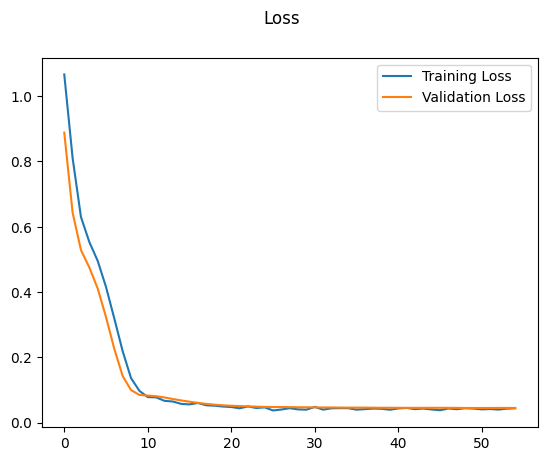

Result:

     Accuracy  F1 Score  Precision    Recall
07F  0.988432  0.663664   0.994048  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       274
      Normal       0.98      1.00      0.99       495
      Replay       0.00      0.00      0.00         9

    accuracy                           0.99       778
   macro avg       0.66      0.67      0.66       778
weighted avg       0.98      0.99      0.98       778



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


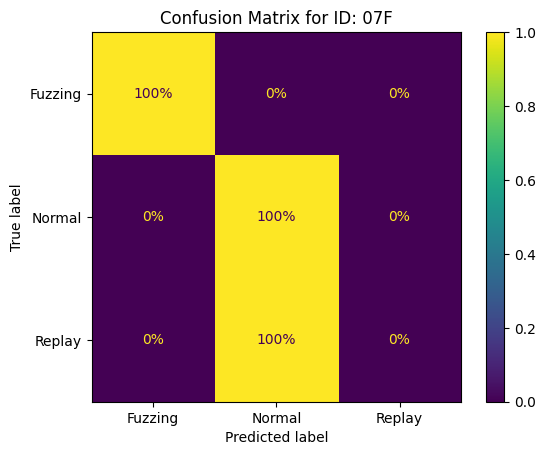

<Figure size 800x600 with 0 Axes>





Processing ID: 57F
Epoch 1/100
5/5 [==============================] - 2s 118ms/step - loss: 1.0869 - accuracy: 0.4164 - val_loss: 1.0500 - val_accuracy: 0.5668
Epoch 2/100
5/5 [==============================] - 0s 29ms/step - loss: 1.0350 - accuracy: 0.5070 - val_loss: 0.9857 - val_accuracy: 0.6842
Epoch 3/100
5/5 [==============================] - 0s 24ms/step - loss: 0.9717 - accuracy: 0.5261 - val_loss: 0.9078 - val_accuracy: 0.6842
Epoch 4/100
5/5 [==============================] - 0s 22ms/step - loss: 0.8941 - accuracy: 0.5610 - val_loss: 0.8179 - val_accuracy: 0.6842
Epoch 5/100
5/5 [==============================] - 0s 25ms/step - loss: 0.8172 - accuracy: 0.5627 - val_loss: 0.7319 - val_accuracy: 0.6842
Epoch 6/100
5/5 [==============================] - 0s 30ms/step - loss: 0.7570 - accuracy: 0.5697 - val_loss: 0.6766 - val_accuracy: 0.6842
Epoch 7/100
5/5 [==============================] - 0s 32ms/step - loss: 0.7257 - accuracy: 0.5697 - val_loss: 0.6559 - val_accuracy: 0.6

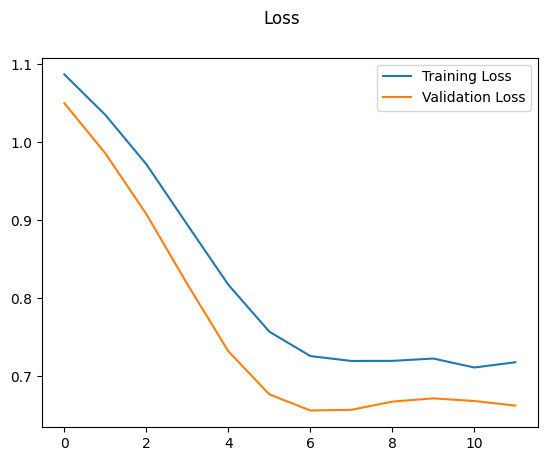

Result:

     Accuracy  F1 Score  Precision    Recall
57F   0.52741  0.230198    0.84247  0.333333

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       0.53      1.00      0.69       279
      Normal       0.00      0.00      0.00       246
      Replay       0.00      0.00      0.00         4

    accuracy                           0.53       529
   macro avg       0.18      0.33      0.23       529
weighted avg       0.28      0.53      0.36       529



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


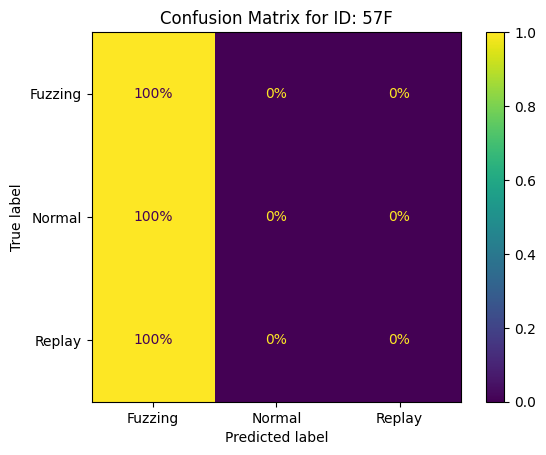

<Figure size 800x600 with 0 Axes>





Processing ID: 5B0
Epoch 1/100
7/7 [==============================] - 2s 61ms/step - loss: 1.0555 - accuracy: 0.8088 - val_loss: 0.9485 - val_accuracy: 0.9914
Epoch 2/100
7/7 [==============================] - 0s 17ms/step - loss: 0.9133 - accuracy: 0.9926 - val_loss: 0.7606 - val_accuracy: 0.9914
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 0.7333 - accuracy: 0.9926 - val_loss: 0.5310 - val_accuracy: 0.9914
Epoch 4/100
7/7 [==============================] - 0s 17ms/step - loss: 0.5383 - accuracy: 0.9926 - val_loss: 0.3412 - val_accuracy: 0.9914
Epoch 5/100
7/7 [==============================] - 0s 18ms/step - loss: 0.3571 - accuracy: 0.9926 - val_loss: 0.1866 - val_accuracy: 0.9914
Epoch 6/100
7/7 [==============================] - 0s 17ms/step - loss: 0.1810 - accuracy: 0.9926 - val_loss: 0.0810 - val_accuracy: 0.9914
Epoch 7/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0763 - accuracy: 0.9926 - val_loss: 0.0548 - val_accuracy: 0.99

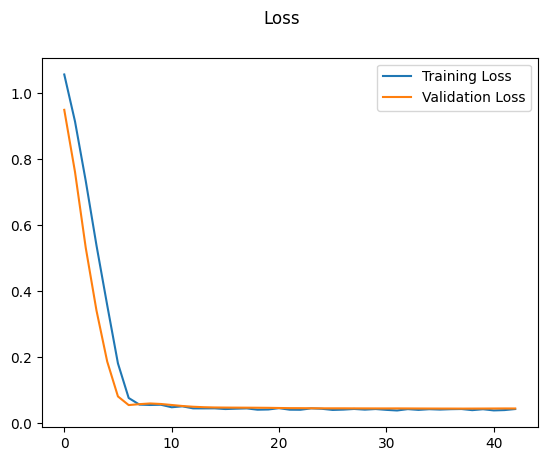

Result:

     Accuracy  F1 Score  Precision    Recall
5B0   0.98822  0.663652   0.994024  0.666667

Classification Report:
              precision    recall  f1-score   support

     Fuzzing       1.00      1.00      1.00       262
      Normal       0.98      1.00      0.99       493
      Replay       0.00      0.00      0.00         9

    accuracy                           0.99       764
   macro avg       0.66      0.67      0.66       764
weighted avg       0.98      0.99      0.98       764



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


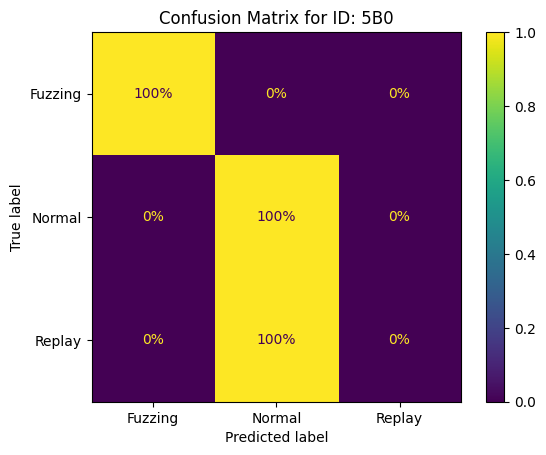

<Figure size 800x600 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

id_total_results = pd.DataFrame()

for data_id in ids:
    print(f"Processing ID: {data_id}")
    X_train, X_test, y_train, y_test, class_labels = id_train_test_set(dfs_by_id_train, dfs_by_id_test, data_id)
    y_pred = model_train(X_train, X_test, y_train, y_test, class_labels)
    evaluation_results={}

    # 각 모델에 대해 예측을 수행하고 평가 지표를 계산
    # Acccuracy, precision, recall, f1-score 계산
    modelAcc_1= accuracy_score(y_test, y_pred)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=1.0)

    # 결과를 딕셔너리에 저장
    evaluation_results[data_id] = {
        'Accuracy': modelAcc_1,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

    print('Result:\n')
    print(pd.DataFrame(evaluation_results).T)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_labels))

    # 혼동 행렬 계산 및 시각화
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_labels, normalize='true', values_format='.0%')

    # 시각화
    plt.title(f'Confusion Matrix for ID: {data_id}')
    #disp.plot(cmap=plt.cm.Blues)
    plt.figure(figsize=(8, 6))
    #cm = confusion_matrix(y_test, y_pred)
    plt.show()
    print("\n" + "="*80 + "\n")

    # 각 아이디별, 모델별 결과 저장
    id_total_results = pd.concat([id_total_results, pd.DataFrame(evaluation_results)], axis=1)
    print("\n" + "="*80 + "\n")

### 모든 ID들의 성능의 평균치 계산
- Accuracy, F1-score, Precision의 평균 계산

In [ ]:
id_total_results

,251,2B0,381,340,260,47F,329,164,387,394,...,483,4A2,50A,043,544,559,410,07F,57F,5B0
Accuracy,0.980944,0.980991,0.980878,0.980903,1.0,0.980946,0.980758,0.980994,0.974926,0.980920,...,0.973861,0.984472,0.985307,0.994214,0.979555,0.982285,0.982655,0.988432,0.527410,0.988220
F1 Score,0.662577,0.663431,0.662148,0.663435,1.0,0.663428,0.659877,0.663433,0.764345,0.662785,...,0.646775,0.663327,0.662709,0.897992,0.657850,0.663388,0.663401,0.663664,0.230198,0.663652
Precision,0.993574,0.993591,0.993560,0.993598,1.0,0.993585,0.993551,0.993596,0.771371,0.993574,...,0.990387,0.993386,0.994711,0.996008,0.992478,0.993506,0.993531,0.994048,0.842470,0.994024
Recall,0.664980,0.666667,0.664141,0.666667,1.0,0.666667,0.659674,0.666667,0.757876,0.665394,...,0.637931,0.666667,0.664093,0.846154,0.656790,0.666667,0.666667,0.666667,0.333333,0.666667


In [ ]:
id_total_results.mean(axis='columns')

Accuracy     0.952664
F1 Score     0.645621
Precision    0.969286
Recall       0.659951
dtype: float64

In [ ]:
output_file = '/content/drive/MyDrive/CAN/submit_filter_data/ANN_performance_scores_by_id_datadiff.csv'
id_total_results.to_csv(output_file, index=False)